In [1]:
require(data.table)
require(dada2)
require(phyloseq)
require(ggplot2)
require(RColorBrewer)
library("DESeq2")
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: data.table

Loading required package: dada2

Loading required package: Rcpp

Loading required package: phyloseq

Loading required package: ggplot2

Loading required package: RColorBrewer

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, pas

In [2]:
meta=fread("~/Documents/DE/DE_16S/DE16S_allmeta.csv")
asv_all=fread("~/Documents/DE/DE_16S/ASVs/Run123_ASV_nochim.csv")
taxa=read.csv("~/Documents/DE/DE_16S/ASVs/Run123_taxa.csv", header=TRUE, row.names=1)

In [3]:
#fix rownames
rows=as.vector(asv_all[,1])
asv_all=asv_all[,-1]
asv_all=apply(asv_all, 2, as.numeric)
row.names(asv_all)=rows$V1

In [4]:
#pull out the dilution effect samples
meta_de=meta[meta$Experiment=="Field17"|meta$Experiment=="Lab18",]

In [5]:
asv_de=asv_all[rownames(asv_all) %in% meta_de$UniqueID,]

In [6]:
asv_de=asv_de[,colSums(asv_de)>0]

In [7]:
taxa_de=taxa[rownames(taxa)%in% colnames(asv_de),]
taxa_de=as.matrix(taxa_de)

In [8]:
taxa_de=as.matrix(taxa_de)
meta_de=as.data.frame(meta_de)
row.names(meta_de)=meta_de$UniqueID

In [9]:
OTU = otu_table(t(asv_de), taxa_are_rows = TRUE)
TAX = tax_table(taxa_de)
SAMP=sample_data(meta_de)

In [10]:
table(SAMP$RFTM_score)


  0 0.5   1   2   3   4   5 
116  18  30  24  16   6   3 

In [11]:
#make peacrabs into a factor
SAMP$peacrabs=factor(SAMP$peacrabs)

In [12]:
#SAMP$RFTM_score=factor(SAMP$RFTM_score)

In [13]:
#make a simpler rftm factor without 0.5 and combining 4 and 5
SAMP$RFTM_simp=factor(SAMP$RFTM_score)
SAMP$RFTM_simp=sub("0.5", "1", SAMP$RFTM_simp)
SAMP$RFTM_simp=sub("5", "4", SAMP$RFTM_simp)

In [14]:
#make RFTM presence absence
SAMP$RFTM_pa=ifelse(SAMP$RFTM_score=="0", 0, 1)
SAMP$RFTM_pa=factor(SAMP$RFTM_pa)

In [15]:
#transform otu counts
OTU=transform_sample_counts(OTU, function(x) 1000000 * x/sum(x))

In [16]:
#make phyloseq object
DE = phyloseq(OTU, TAX, SAMP)

In [17]:
#separate 2017 and 2018
DE17=subset_samples(DE, Year=="2017")
DE18=subset_samples(DE, Year=="2018")

In [18]:
SAMP17=sample_data(DE17)

In [19]:
table(SAMP17$RFTM_score)


  0 0.5   1   2   3   4   5 
 34  10  26  22  14   5   1 

## significant OTUs with presence absence of perkinsus

In [20]:
DE17ddsrftm = phyloseq_to_deseq2(DE17, ~ Site+RFTM_pa)
DE17ddsrftm = DESeq(DE17ddsrftm, test="Wald", fitType="parametric")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7883 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [21]:
respa = results(DE17ddsrftm, contrast=c("RFTM_pa", "0", "1"))
alpha = 0.05
sigpa = respa[which(respa$padj < alpha), ]
sigpa = cbind(as(sigpa, "data.frame"), as(tax_table(DE17)[rownames(sigpa), ], "matrix"))

In [22]:
dim(sigpa)

[1] 446  12

In [23]:
sigpa_pos=sigpa[sigpa$log2FoldChange>0,]
dim(sigpa_pos)

[1] 241  12

In [24]:
sigpa_neg=sigpa[sigpa$log2FoldChange<0,]
dim(sigpa_neg)

[1] 205  12

In [25]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(50)

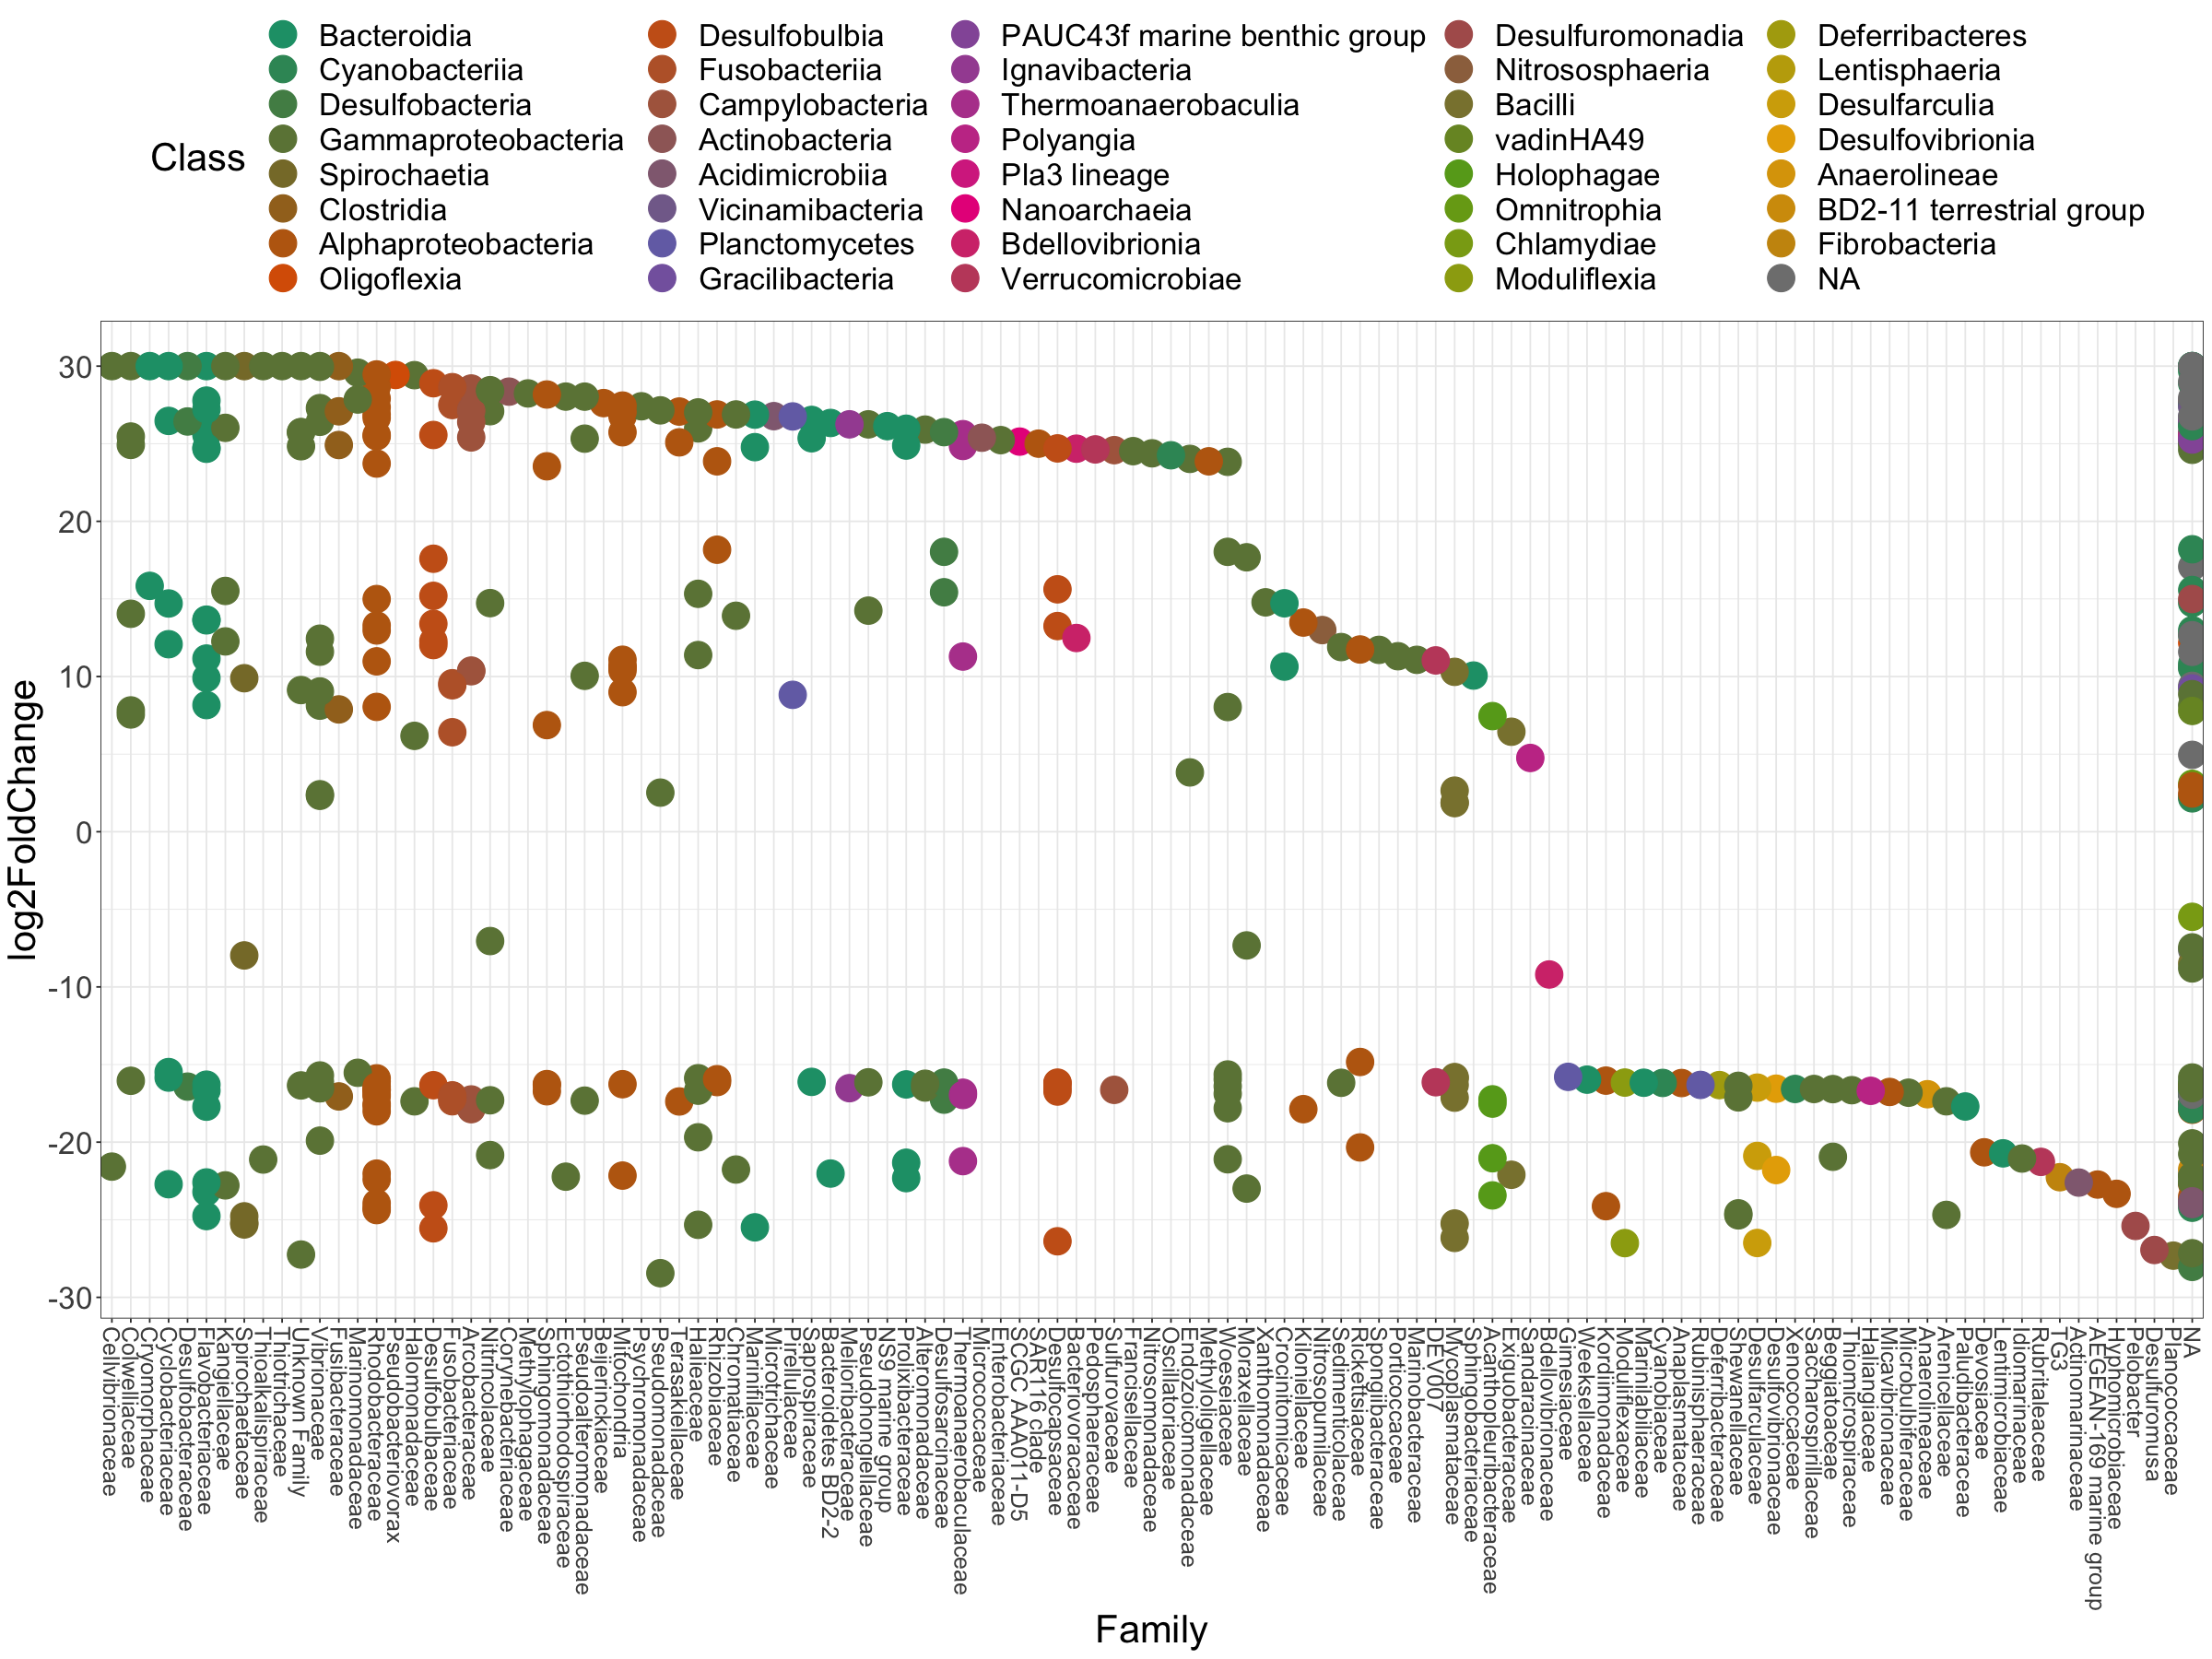

In [26]:
# Phylum order
x = tapply(sigpa$log2FoldChange, sigpa$Class, function(x) max(x))
x = sort(x, TRUE)
sigpa$Class = factor(as.character(sigpa$Class), levels=names(x))
# Genus order
x = tapply(sigpa$log2FoldChange, sigpa$Family, function(x) max(x))
x = sort(x, TRUE)
sigpa$Family = factor(as.character(sigpa$Family), levels=names(x))
ggplot(sigpa, aes(x=Family, y=log2FoldChange, color=Class)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           theme_bw()+
  theme(legend.position="top",axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=15), text=element_text(size=25))
           #ylim(-25,25)

## significant OTUs with numeric RFTM score 

In [27]:
DE17ddsrftm = phyloseq_to_deseq2(DE17, ~ Site+RFTM_score)
DE17ddsrftm = DESeq(DE17ddsrftm, test="Wald", fitType="parametric")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7733 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [28]:
resultsNames(DE17ddsrftm)

[1] "Intercept"     "Site_OY_vs_NW" "Site_SW_vs_NW" "RFTM_score"

In [29]:
resnum = results(DE17ddsrftm, name=c("RFTM_score"))
alpha = 0.05
signum = resnum[which(resnum$padj < alpha), ]
signum = cbind(as(signum, "data.frame"), as(tax_table(DE17)[rownames(signum), ], "matrix"))

In [30]:
dim(signum)

[1] 459  12

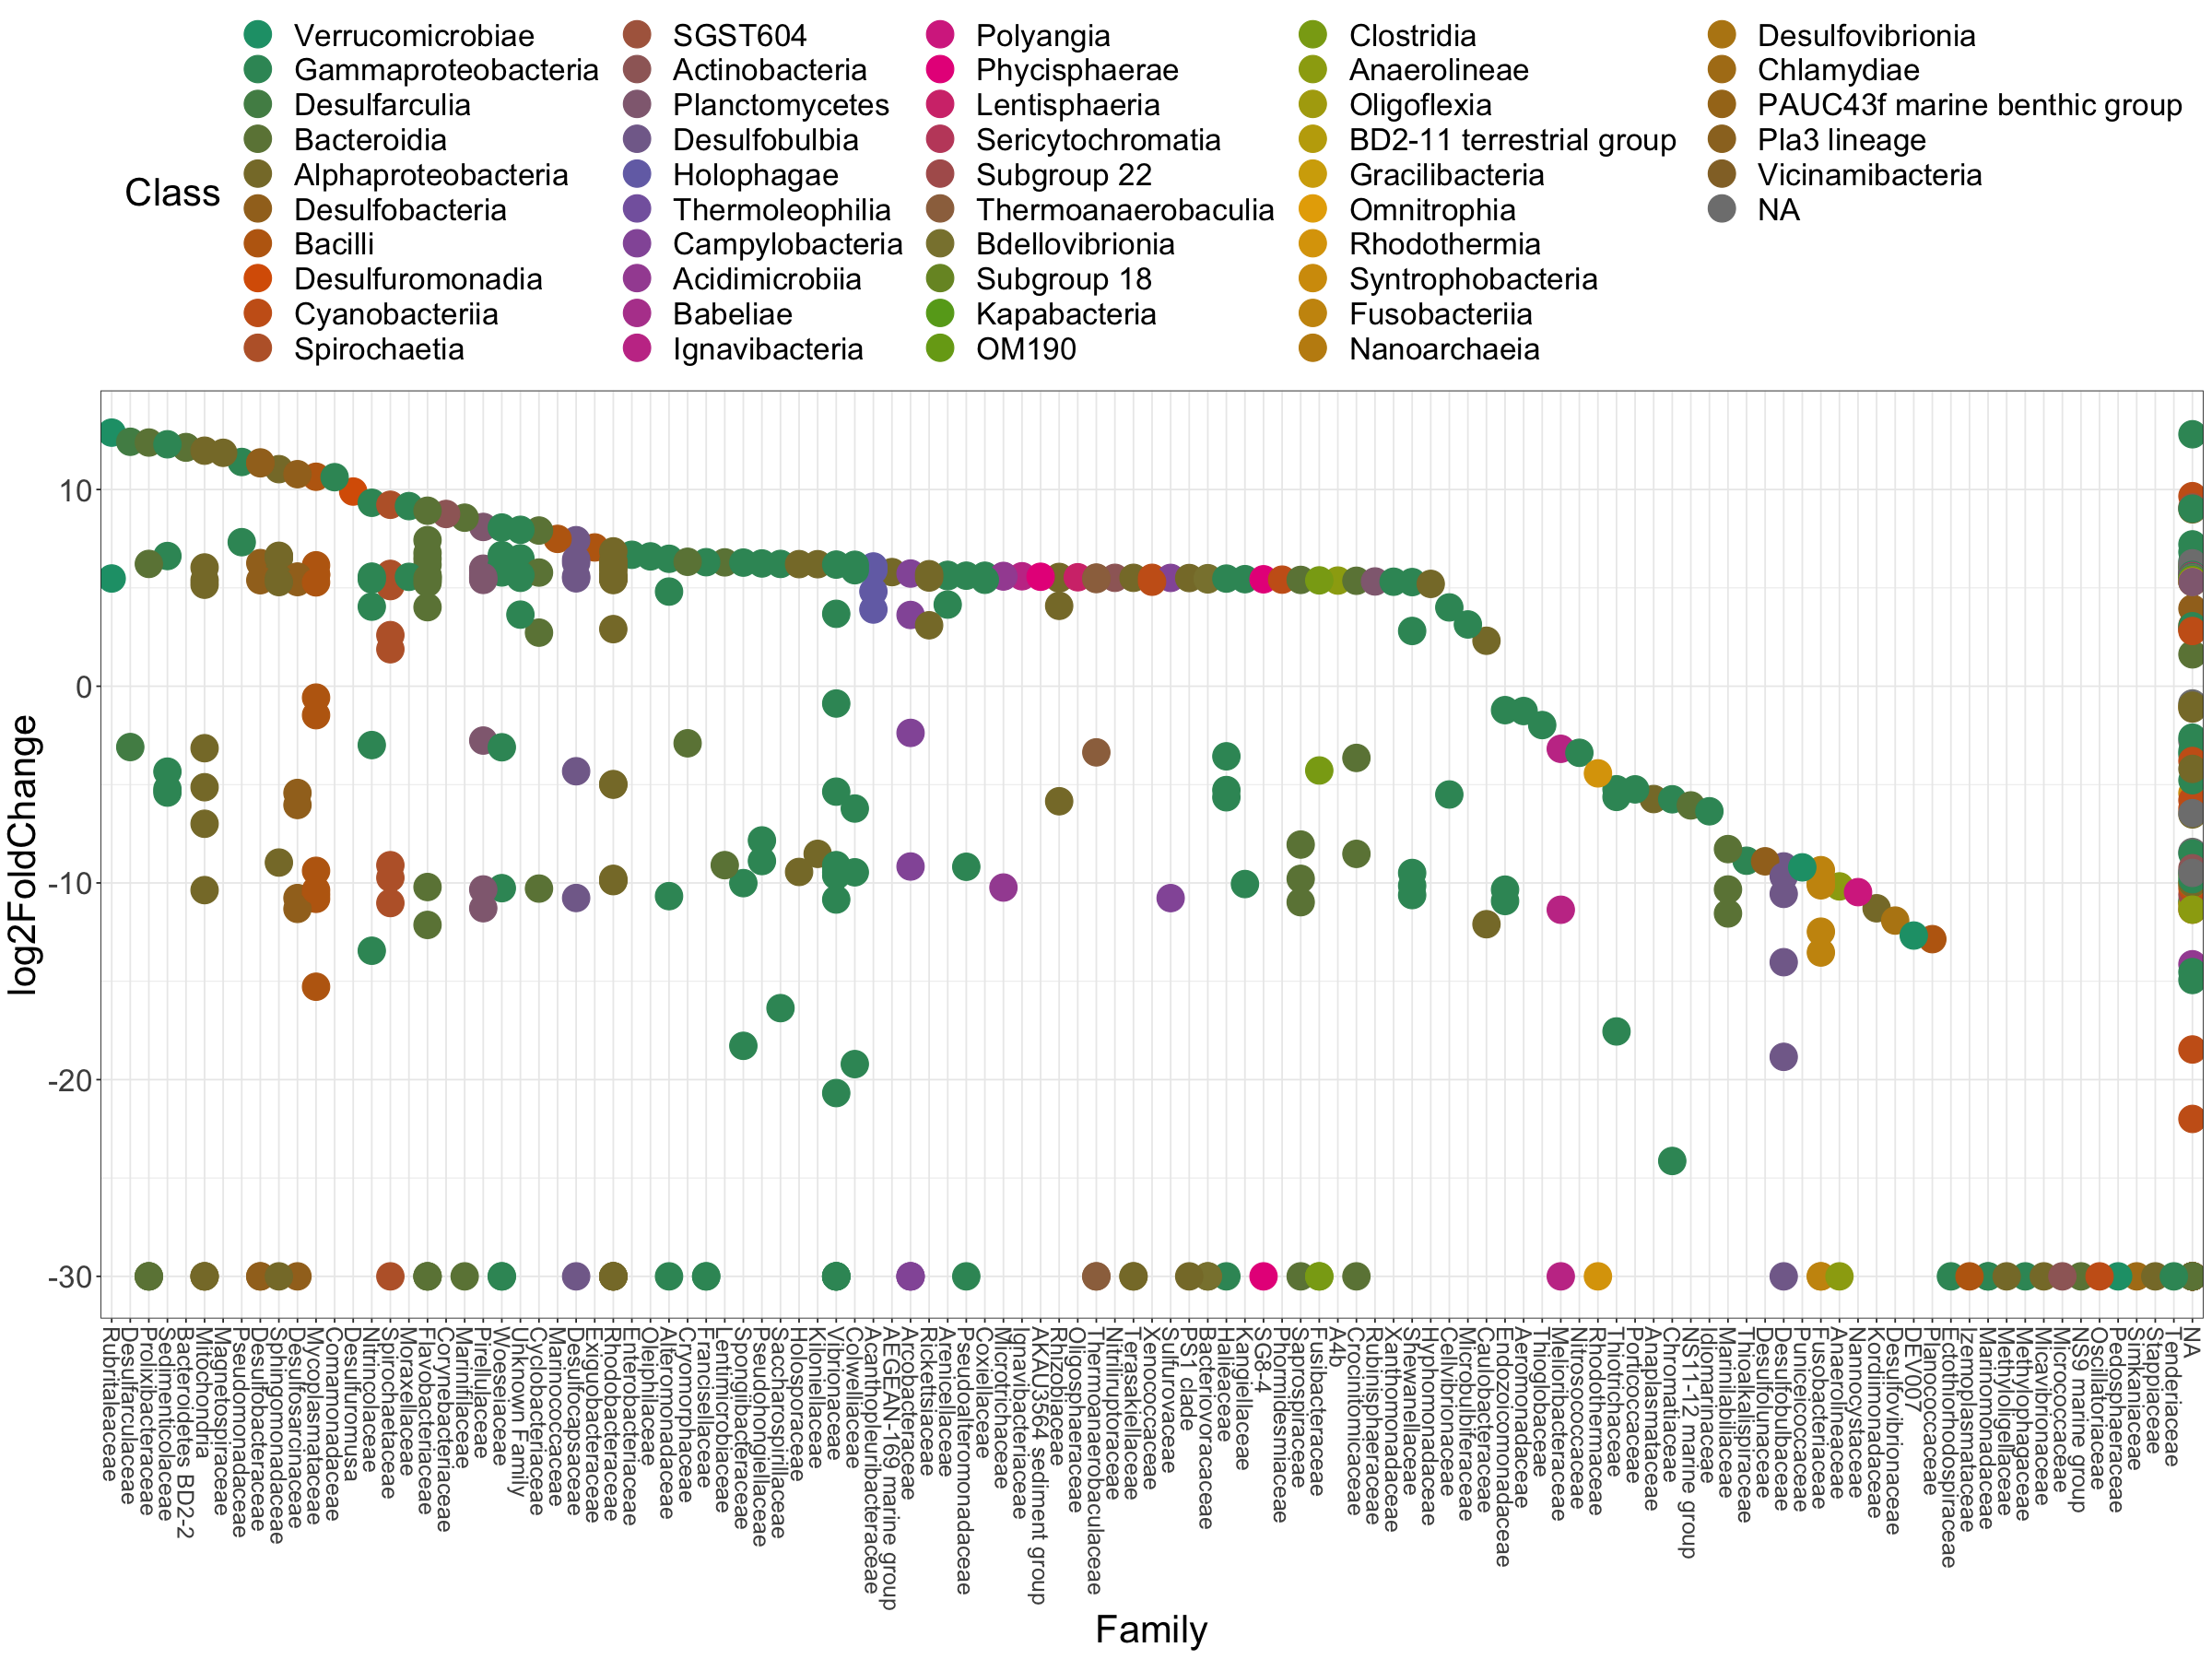

In [31]:
# Phylum order
x = tapply(signum$log2FoldChange, signum$Class, function(x) max(x))
x = sort(x, TRUE)
signum$Class = factor(as.character(signum$Class), levels=names(x))
# Genus order
x = tapply(signum$log2FoldChange, signum$Family, function(x) max(x))
x = sort(x, TRUE)
signum$Family = factor(as.character(signum$Family), levels=names(x))
ggplot(signum, aes(x=Family, y=log2FoldChange, color=Class)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           theme_bw()+
  theme(legend.position="top",axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=15), text=element_text(size=25))
           #ylim(-25,25)

In [32]:
signum_pos=signum[signum$log2FoldChange>0,]
dim(signum_pos)

[1] 211  12

In [33]:
signum_neg=signum[signum$log2FoldChange<0,]
dim(signum_neg)

[1] 248  12

## overlap between pa and numeric perkinsus otus

In [34]:
perkpos=merge(signum_pos, sigpa_pos, by="row.names")

In [35]:
perkpos

Row.names                                                                                                                                                                                                                                                    
1 GACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGAGCGCGTAGGTGGTTTAGTAAGTTAGAAGTGAAATCCCGGGGCTTAACCTCGGAACTGCTTTTAAAACTGCTTTACTAGAGTATGGTAGAGGATGGTAGAATTCCTAGTGTAGAGGTGGAATTCTTAGATATTAGGAGGAATACCGGTGGCGAAGGCGACCATCTGGGCCATAACTGACACTGATGCGCGAAAGCGTGGGGAGCAAACAGG
  baseMean.x log2FoldChange.x lfcSE.x  stat.x   pvalue.x    padj.x    
1 43.21344   3.099122         1.203143 2.575855 0.009999244 0.02202081
  Kingdom.x Phylum.x       Class.x             ⋯ lfcSE.y  stat.y   pvalue.y    
1 Bacteria  Proteobacteria Alphaproteobacteria ⋯ 3.171604 3.702399 0.0002135707
  padj.y       Kingdom.y Phylum.y       Class.y             Order.y      
1 0.0006384874 Bacteria  Proteobacteria Alphaproteobacteria Rickettsiales
  Family.y       Genus.y
1 Rickettsiaceae NA

In [36]:
perkneg=merge(signum_neg, sigpa_neg, by="row.names")

In [37]:
perkneg

Row.names                                                                                                                                                                                                                                                      
1  AACAGAGGATGCAAGCGTTATCCGGAATTATTGGGCGTAAAGTGTCTGTAGGTGGCTTTTCAAGTCCGTCGTCAAATCCCAGGGCTCAACCCTGGACAGGCGGTGGAAACTATTAAGCTAGAGTACGGTAGAGGCAGAGGGAATTTCCGGTGGAGCGGTGAAATGCGTTGAGATCGGGAGGAACACCAAGGGCGAAAGCACTCTGCTGGGCCGTTACTGACACTCAGAGACGAAAGCTAGGGGAGCAAATGGG  
2  TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCCTGGGGCTCAACCCCAGTCCGCTTTGGATACTGGTAGACTAGAGTTATAGAGAGGTTAGTGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAACTAACTGGCTATATACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG   
3  TACGAAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGAGTACGTAGGCGGTTAGATTAGTTAGGTGTGAAATCCCGGAGCTCAACTTCGGAGTTGCACTTAATACTGTTTAACTAGAATTCAAGAGGGGAGAGTGGAATTTCCAGTGTAGGGGTGATATCCGTAGATATTGGAAGGAACATCAGAGGCGAAGGCGACTCTCTGGCTTGATATTGACGCTGAGGTACGAAAGCGTGGGTAGCAAACAGG  
4  TACGAAGGGGGCTAGCGTTGTTCGGAATAACTGGGCGTAAAGCGCACGTAGGCGGATTGGAAAGTTAGAGGTGAAATCCCAGGGCTCAACCCTGGAACTGCCTTTAAAACTATCAGTCTAGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGTGTGGGGAGCAAACAGG  
5  TACGGAGGGGGCGAGCGTTATTCGGAATTATTGGGTGTAAAGTGTGCGTAGGCGGCTTAGTAAGTTAATGGTGAAATCCCGGGGCTCAACCCCGGGGCTGCTTTTAGAACTGCTAAGCTGGAGTTGGAAAGAGGATAGCAGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAGGAATACCGGAGGCGAAGGCGGCTGTCTGGTTCCATACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG  
6  TACGGAGGGGGCTAGCGTTATTCGGAATTATTGGGCGTAAAGGGCGCGCAGGCGGCTTGGTAGGTCAAAGGTGAAATCCCTCAGCTCAACTGAGGAACTGCCTTTGAAACCACCTCGCTAGAGGCTGGGAGGGGATAGCGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCTATCTGGACCAGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG  
7  TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTTGATACTGGCAAACTAGAGTATGAGAGAGAGAAGTGGAATTCCACATGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACATCAGTGGCGAAGGCGACTTCTTGGCTCAATACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG  
8  TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGCTATATAAGTCAGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTTGATACTGTATAGCTAGAGTTTGGTAGAGGGAAGTGGAATTCCACATGTAGCGGTGAAATGCGTAGATATGTGGAGGAACACCAGTGGCGAAGGCGACTTCCTGGACCAAAACTGACGCTGAGGTGCGAAAGCGTGGGTAGCAAACAGG  
9  TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGCTTGTTAAGCAAGATGTGAAAGCCCCGGGCTCAACCTGGGAATGGCATTTTGAACTGGCAGGCTCGAGTTCTGAAGAGGGTGGTAGAATTTCCAGTGTAGCGGTGAAATGCGTAGATATTGGAAGGAATACCGGTGGCGAAGGCGGCCACCTGGTCAGAAACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG  
10 TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTGCGTAGGTGGCCCGATCAGTCAGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATTTGATACTGTCGAGCTAGAGTATGGTAGAGGGAAGTGGAATTCCGGGTGTAGCGGTGAAATGCGTAGATATCCGGAGGAACACCAGTGGCGAAGGCGACTTCCTGGACCAATACTGACACTGAGGCACGAAAGCGTGGGTAGCAAACAGG  
11 TACGGAGGGTGCAAGCGTTGTCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATATTAAGTCAGTGGTGAAAGCCCACAGCTCAACTGTGGAACTGCCATTGATACTGATATTCTTGAGTACGGATGAGGTAAGCGGAATTTATGGTGTAGCGGTGAAATGCATAGATACCATAAAGAACACCGATAGCGAAGGCAGCTTACTAGGCCGTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCGAACAGG  
12 TACGGAGGGTGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGAGCGTGTAGGCGGCCAAGTCAGTCAGATGTGAAAGCCCGTGGCTTAACTGCGGAAGTGCATCTGATACTGCTTGGCTTGAGTCTCGGAGAGGGGTGTGGAATTCCCGGTGTAGAGGTGAAATTCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGACACCCTGGACGATGACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG  
13 TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAACTGCATTTGAAACTGATAAACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCAGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG  
14 TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGTTAAGTCGGATGTGAAAGCCCTGGGCTCAACCTGGGAACTGCATTCGATACTGACCGACTAGAGTACGAGAGAGGGAGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAATACCGGTGGCGAAGGCGGCCTCCTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG  
15 TACGTAGGGAGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGCGAGCGCAGGCGGGTTAGTAAGTCAGAGGTGAAATCTCACAGCTTAACTGTGAAATTGCCTTTGATACTGCTA

## significant OTUs contrasting each RFTM score with higher value

In [38]:
DE17ddsrftm = phyloseq_to_deseq2(DE17, ~ Site+RFTM_simp)
DE17ddsrftm = DESeq(DE17ddsrftm, test="Wald", fitType="parametric")


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7629 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [39]:
res01 = results(DE17ddsrftm, contrast=c("RFTM_simp", "0", "1"))
alpha = 0.05
sig01 = res01[which(res01$padj < alpha), ]
sig01 = cbind(as(sig01, "data.frame"), as(tax_table(DE17)[rownames(sig01), ], "matrix"))
sig01_pos=sig01[sig01$log2FoldChange>0,]

In [40]:
res12 = results(DE17ddsrftm, contrast=c("RFTM_simp", "1", "2"))
alpha = 0.05
sig12 = res01[which(res12$padj<alpha),]
sig12 = cbind(as(sig12,"data.frame"), as(tax_table(DE17)[rownames(sig12), ], "matrix"))
sig12_pos=sig12[sig12$log2FoldChange>0,]

In [41]:
res23 = results(DE17ddsrftm, contrast=c("RFTM_simp", "2", "3"))
alpha = 0.05
sig23 = res23[which(res23$padj<alpha),]
sig23 = cbind(as(sig23,"data.frame"), as(tax_table(DE17)[rownames(sig23), ], "matrix"))
sig23_pos=sig23[sig23$log2FoldChange>0,]

In [42]:
res34 = results(DE17ddsrftm, contrast=c("RFTM_simp", "3", "4"))
alpha = 0.05
sig34 = res34[which(res34$padj<alpha),]
sig34 = cbind(as(sig34,"data.frame"), as(tax_table(DE17)[rownames(sig34), ], "matrix"))
sig34_pos=sig34[sig34$log2FoldChange>0,]

In [43]:
sig012_pos=merge(sig01_pos, sig12_pos, by=c("row.names", 'Kingdom','Phylum','Class','Order','Family','Genus'))

In [44]:
rownames(sig012_pos)=sig012_pos$Row.names

In [45]:
sig0123_pos=merge(sig012_pos, sig23_pos, by=c("row.names", 'Kingdom','Phylum','Class','Order','Family','Genus'))

Warning message in merge.data.frame(sig012_pos, sig23_pos, by = c("row.names", "Kingdom", :
“column name ‘Row.names’ is duplicated in the result”


In [46]:
rownames(sig0123_pos)=sig0123_pos$Row.names

In [47]:
sig01234_pos=merge(sig0123_pos, sig34_pos, by=c("row.names", 'Kingdom','Phylum','Class','Order','Family','Genus'))

Warning message in merge.data.frame(sig0123_pos, sig34_pos, by = c("row.names", :
“column names ‘Row.names’, ‘Row.names’, ‘baseMean.x’, ‘log2FoldChange.x’, ‘lfcSE.x’, ‘stat.x’, ‘pvalue.x’, ‘padj.x’, ‘baseMean.y’, ‘log2FoldChange.y’, ‘lfcSE.y’, ‘stat.y’, ‘pvalue.y’, ‘padj.y’ are duplicated in the result”


## significant OTUs with presence absence of peacrabs

In [68]:
DE17dds = phyloseq_to_deseq2(DE17, ~ Site+peacrabs+RFTM_pa)
DE17dds = DESeq(DE17dds, test="Wald", fitType="parametric")


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7669 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [71]:
res = results(DE17dds, contrast=c("peacrabs", "0", "1"))
alpha = 0.05
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(DE17)[rownames(sigtab), ], "matrix"))


In [72]:
dim(sigtab)

[1] 859  12

In [73]:
sig_justpc=sigtab

In [74]:
dim(sig_justpc)

[1] 859  12

In [82]:
write.csv(sig_justpc, file="~/Documents/DE/DE_16S/ASVs/sig_pc.csv")

In [78]:
res = results(DE17dds, contrast=c("RFTM_pa", "0", "1"))
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(DE17)[rownames(sigtab), ], "matrix"))


In [79]:
sig_justperk=sigtab

In [80]:
dim(sig_justperk)

[1] 593  12

In [81]:
write.csv(sig_justperk, file="~/Documents/DE/DE_16S/ASVs/sig_perk.csv")

In [ ]:
res = results(DE17dds, contrast=c("RFTM_pa", "0", "1"))
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(DE17)[rownames(sigtab), ], "matrix"))


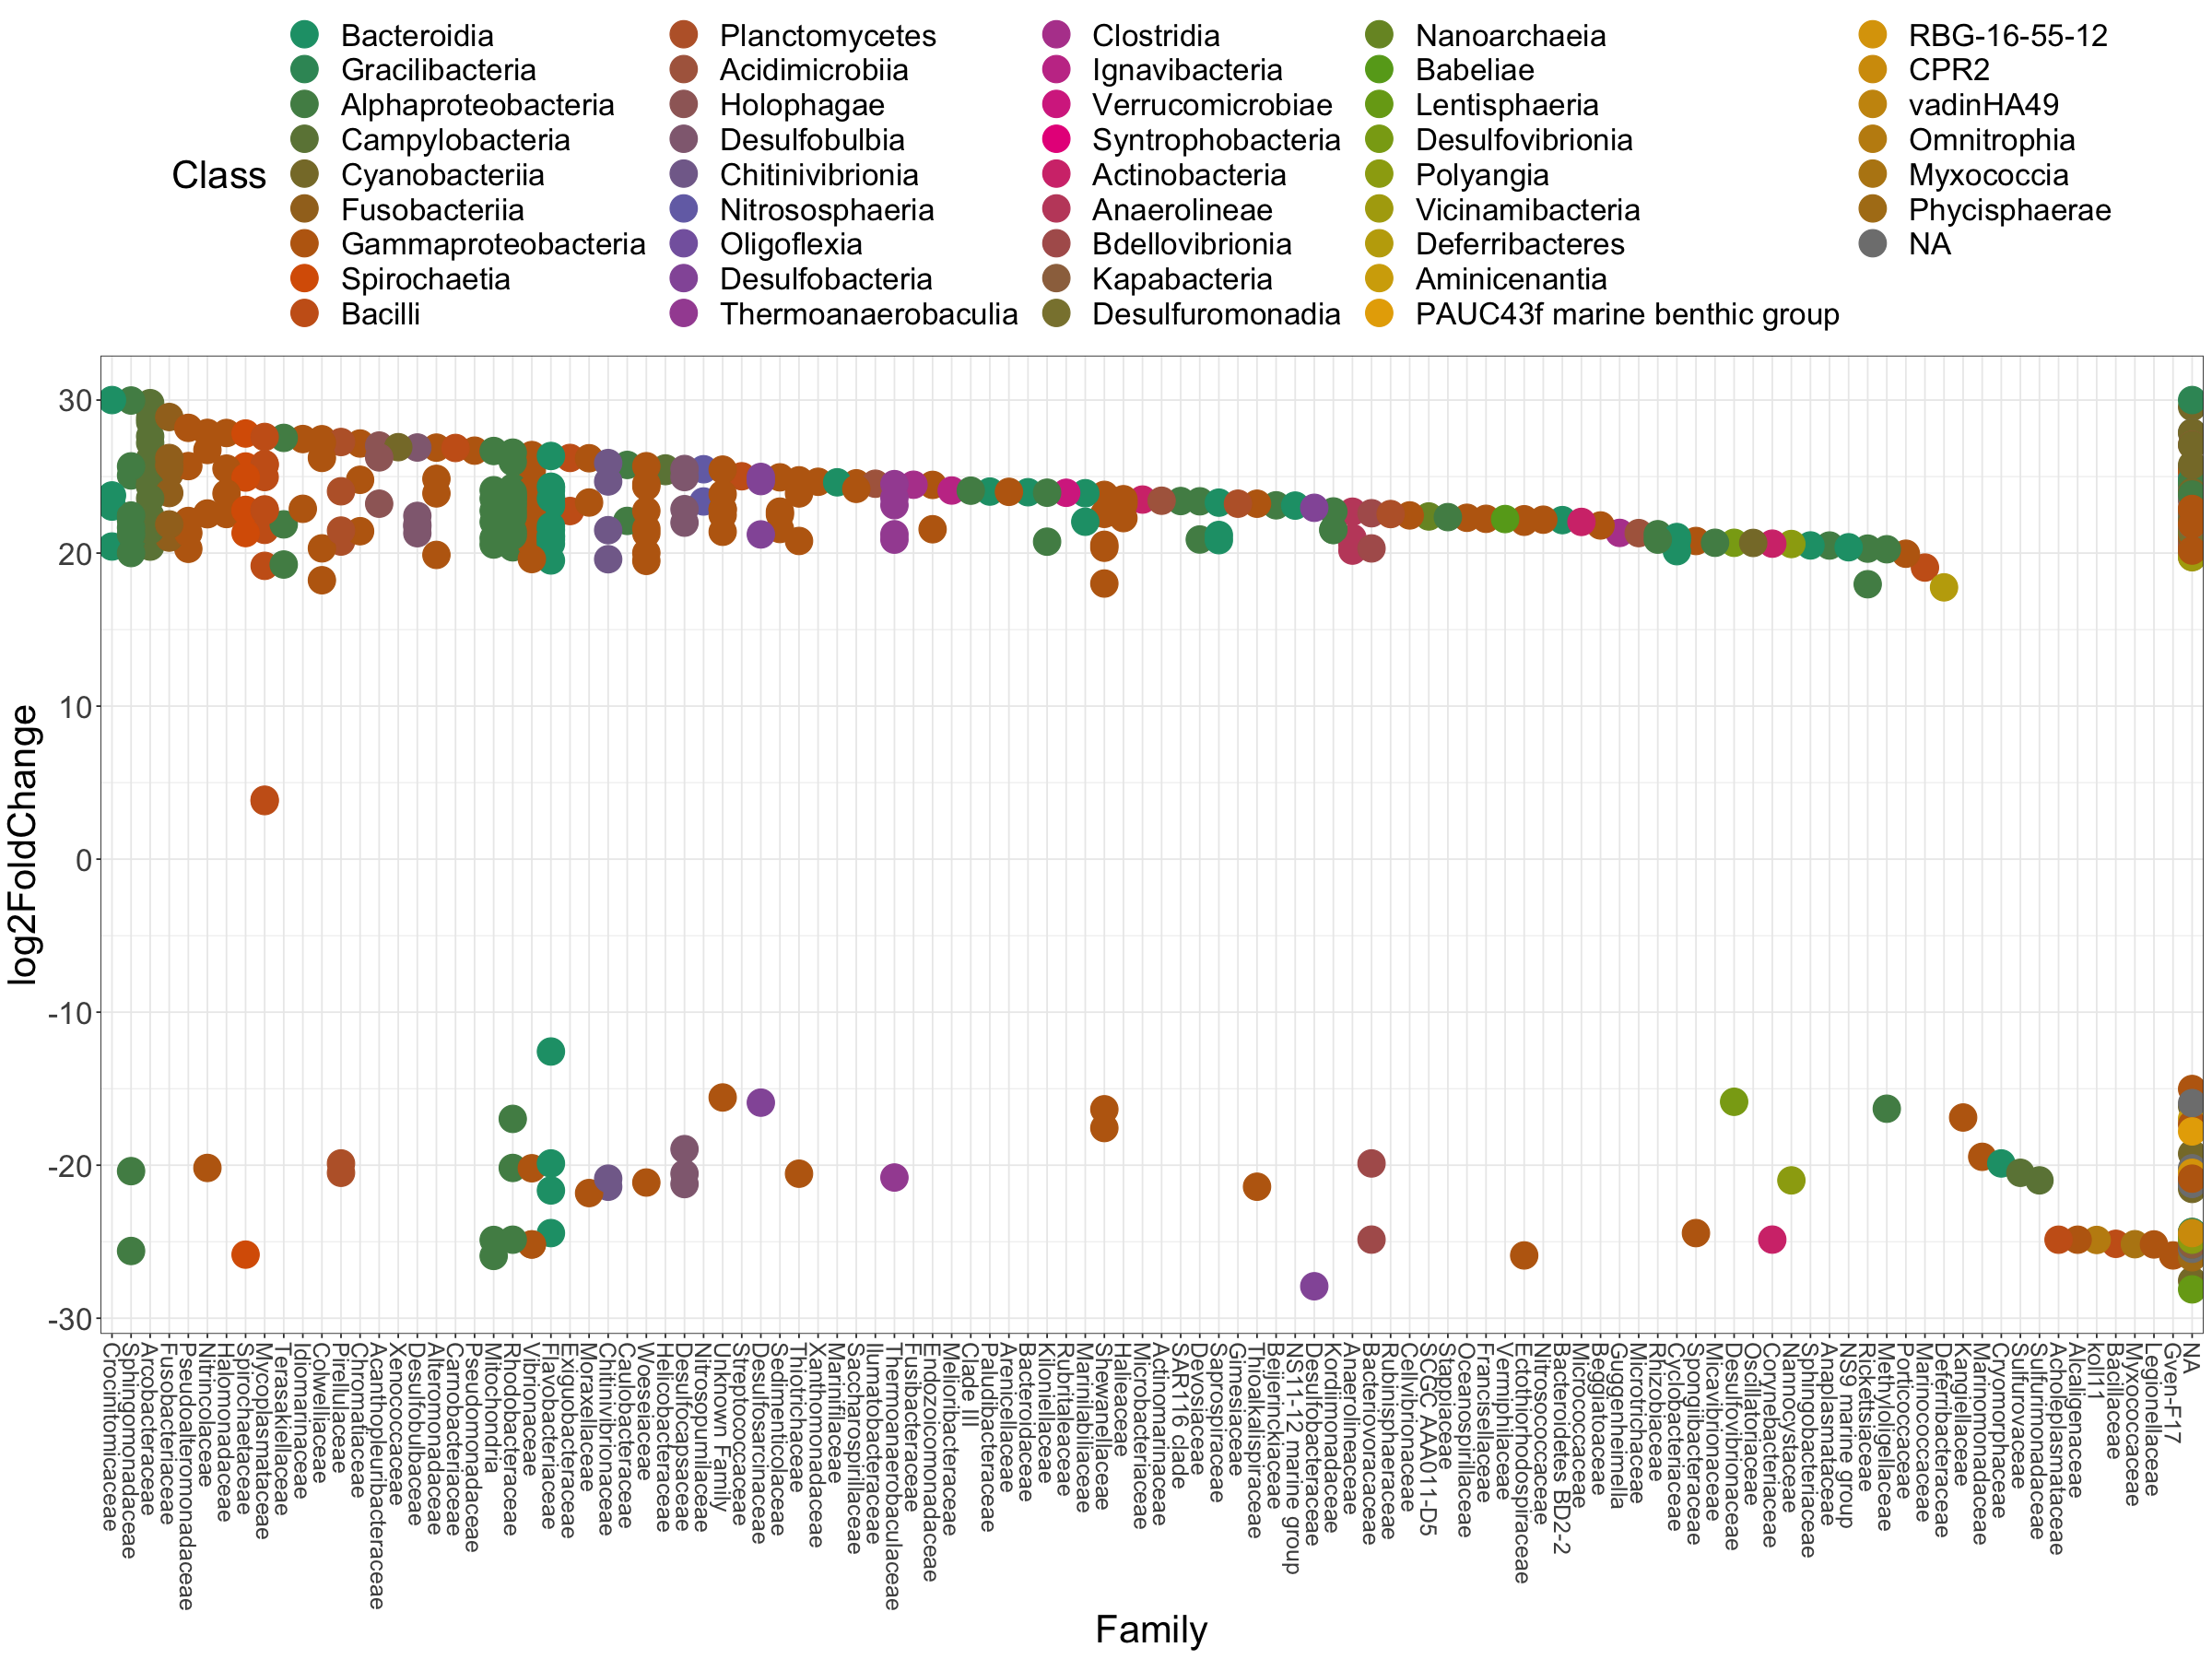

In [54]:
# Phylum order
x = tapply(sig_justpc$log2FoldChange, sig_justpc$Class, function(x) max(x))
x = sort(x, TRUE)
sig_justpc$Class = factor(as.character(sig_justpc$Class), levels=names(x))
# Genus order
x = tapply(sig_justpc$log2FoldChange, sig_justpc$Family, function(x) max(x))
x = sort(x, TRUE)
sig_justpc$Family = factor(as.character(sig_justpc$Family), levels=names(x))
ggplot(sig_justpc, aes(x=Family, y=log2FoldChange, color=Class)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           theme_bw()+
  theme(legend.position="top",axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=15), text=element_text(size=25))
           #ylim(-25,25)

In [55]:
sig_parasites=merge(sig_justpc, sigpa, by=c("row.names", 'Kingdom','Phylum','Class','Order','Family','Genus'))

In [56]:
sig_parasites_pos=sig_parasites[sig_parasites$log2FoldChange.x>0 & sig_parasites$log2FoldChange.y>0,]

In [57]:
sig_parasites_pos

Row.names                                                                                                                                                                                                                                                                        
1   AACCAGCACCTCAAGTGGTCAGGATGATTATTGGGCCTAAAGCATCCGTAGCCGGCTCTGTAAGTTTTCGGTTAAATCTGTACGCTCAACGTACAGGCTGCCGGGAATACTGCAGAGCTAGGGAGTGGGAGAGGTAGACGGTACTCGGTAGGAAGGGGTAAAATCCTTTGATCTATTGATGACCACCTGTGGCGAAGGCGGTCTACCAGAACACGTCCGACGGTGAGGGATGAAAGCTGGGGGAGCAAACCGG                    
2   AACGAGGGGGACAAGCGTTATTCGTCATTACTGGGCGTAAAAGGTTCGTAGACGGTAAAGTAAGTTTCTTTGCTAAAGATTAAAGCCCAACTTTTCAAAAGCTTGTAAATACTGCTTTACTTGAGTTTGATACAAGAGAATAGAATTTTATTTGTAAGGGTAACATCTAATAATAAATAAAGGAATGCCTGAAGCGAAGGCGATTCTCTAGTAAAAACTGACGTTGAGGAACGAAAGTATGGGTAGCAAACAGG                   
3   ACGTGTCAGCCGCGGTAATACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCTCGGTGCTCAACACCGACCCGCTTTGGATACTGATAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG   
4   ACGTGTCAGCCGCGGTAATACGTAGGGGGCGAACGTTGTTCGGAATCACTGGGCGTAAAGGGTGCGCAGGCTGCTCATCAAGTCAGTTGTGAAATTTCGTGGCTCAACCACGAAGCTGCTGCTGATACTGTTGGGCTAGAGTCATAGATAGAGGTAGCGGGAATTCCTGGTGTAGGAGTGAAATCTGTAGATATCAGGAGGAACACCAAGGGTGAAGACAAGCTACTGGGTAATGACTGACGCTGAGGCACGAAAGCTAGGGGAGCAAATGGG
5   CACGGGGGGCGCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTCTTGTCGGTCAGGTGTGAAAGCCCGGGGCTCAACCCTGGAAGTGCACTTGAAACAGCAAGACTTGAGTACGGGAGAGGAAAGCGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGATGGCGAAGGCAGCTTTCTGGACCGATACTGACGCTGAGGCGCGAAGGCGTGGGTAGCGAACGGG                    
8   GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTCAAATAAGTCAACTGTTAAATCTTGAGGCTCAACCTCAAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                    
9   GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTCTAATAAGTCAACTGTTAAATCTTGAGGCTTAACTTCAAAACTGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGATATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                    
11  GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTAAGCAAGTCAACTGTTAAATCTTGAGGCTCAACTTCAAAATCGCAGTCGAAACTGCTTGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGATATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTGACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                    
14  GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTGAGGCTCAACTTCAAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGAGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAAGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                    
15  GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTGAGGCTCAACTTCAAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTGACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                    
16  GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTGATAAGTCAACTGTTAAATCTTGAAGCTTAACTTCAAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTGACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                    
18  GACGGAGGATGCAAGTGTTATCCGGAATTACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTAAGTCAACTGTTAAATCTTGAGGCTCAACTTCAAATCAGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGATATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                    
32  TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTCAAGAAAGTCTGAAGTTAAAGCTCGGGGCTCAACCCCGACCCGCTTTGGAAACTACTTGACTAGAGTCATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATGAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG                     
33  TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTTAAGTAAGTCTGAAGTTAAAGCCCGGGGCTCAACCCCGGCCCGCTTTGGAAA

In [58]:
sig_parasites_neg=sig_parasites[sig_parasites$log2FoldChange.x<0 & sig_parasites$log2FoldChange.y<0,]

ok thats interesting, so there are more otus that are reduced in both of them...potentially indicating fitness effects? role in immunity? 

# Just look at mycoplasma

In [305]:
DE17_myco = subset_taxa(DE17, Order=="Mycoplasmatales")


In [306]:
DE17_myco


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 176 taxa and 112 samples ]
sample_data() Sample Data:       [ 112 samples by 19 sample variables ]
tax_table()   Taxonomy Table:    [ 176 taxa by 6 taxonomic ranks ]

In [232]:
#get sequences to make a tree and compare to other published seqs
myco_seqs=as.data.frame(tax_table(DE17_myco))

In [234]:
myco_seqs$Sequence=row.names(myco_seqs)

In [236]:
myco_seqs$ASV=paste0("ASV", 1:nrow(myco_seqs) )

In [242]:
myco_seqs=myco_seqs[c(7,8)]

In [248]:
write.table(myco_seqs, file="~/Documents/DE/DE_16S/ASVs/myco_seqs.txt", quote=FALSE, col.names=FALSE)

In [ ]:
#in terminal, run this to convert to fasta
#awk '{print ">"$3"\n"$2}' myco_seqs.txt > myco_seqs.fasta

In [310]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(178)


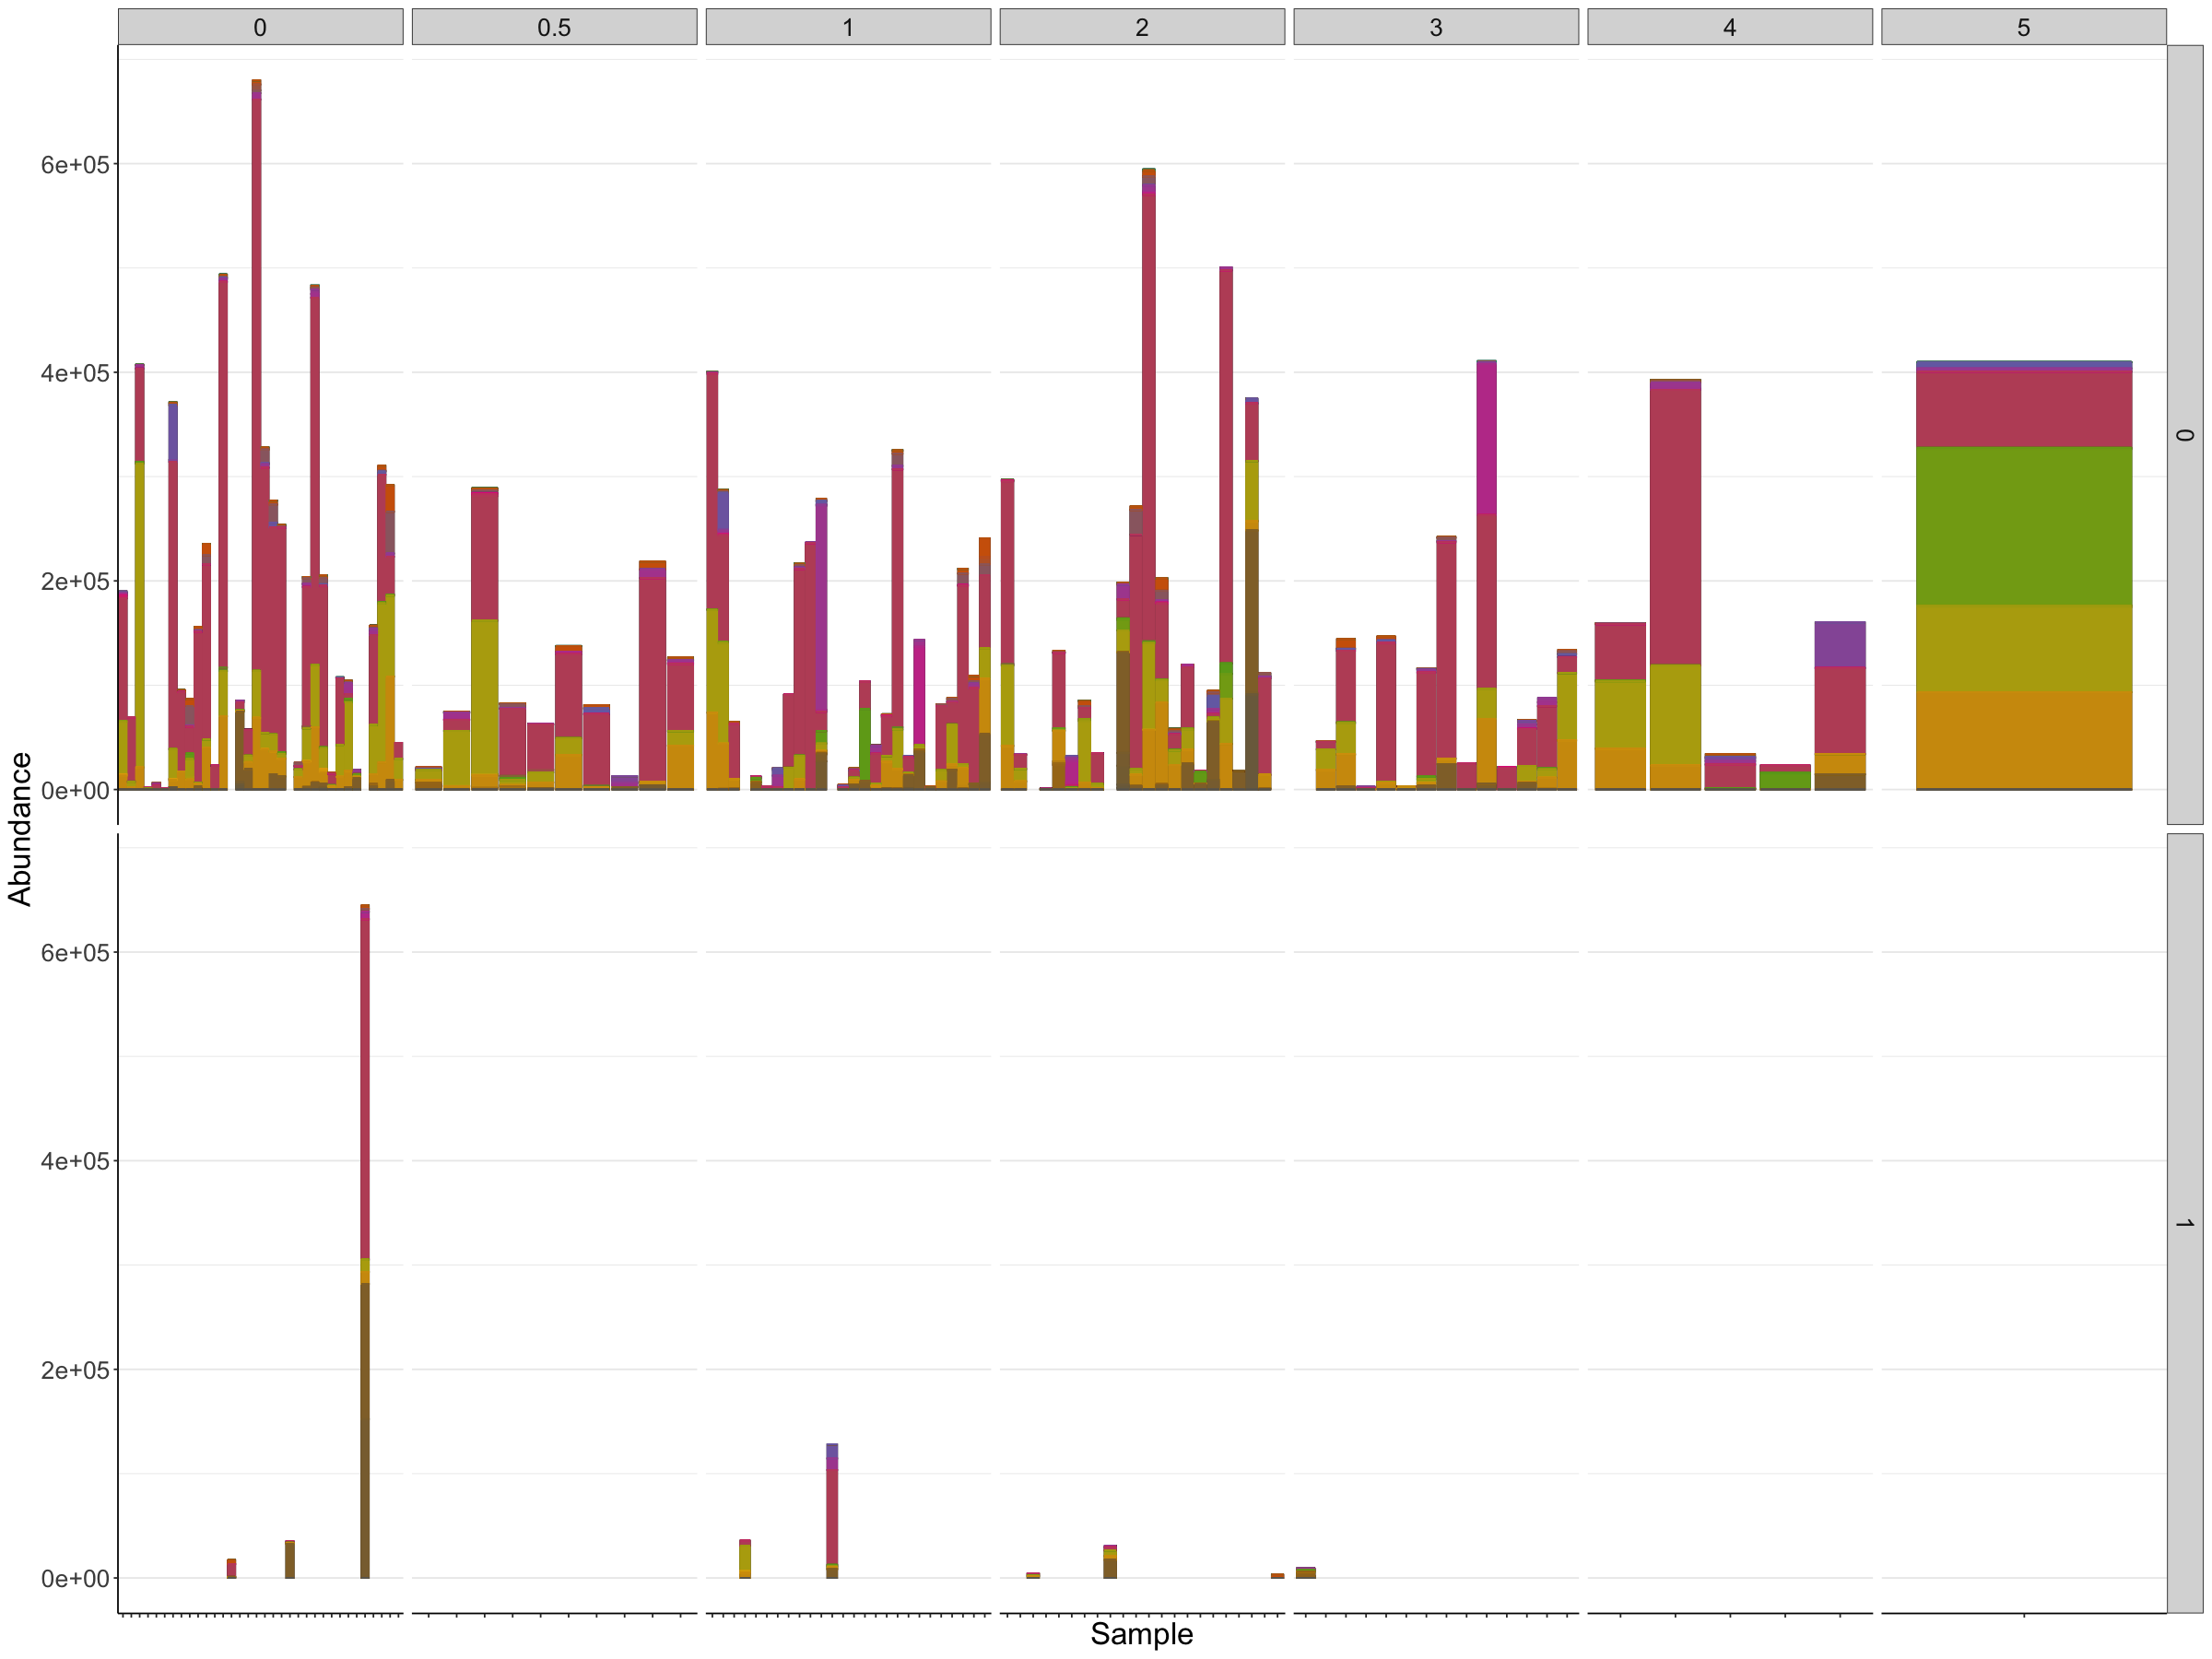

In [315]:
plot_bar(DE17_myco,  x= "Sample", fill="OTU") +
geom_bar(aes(color=OTU, fill=OTU), stat="identity", position="stack")+
facet_grid(peacrabs~RFTM_score, scales = "free_x")+
scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
theme_bw()+
#ylim(0.00001, 400000)+
theme(legend.position="none", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
        axis.line=element_line(color="black"),
      axis.text.x=element_blank(),
          text = element_text(size=20))

## DE2018 data

In [325]:
DE18CV=subset_samples(DE18, Species=="CV")

In [327]:
DE18ddspa = phyloseq_to_deseq2(DE18CV, ~ Treatment1_Density*Treatment2_Diversity+RFTM_pa)

# calculate geometric means prior to estimate size factors because of error every gene contains at least one zero
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(DE18ddspa), 1, gm_mean)
DE18ddspa = estimateSizeFactors(DE18ddspa, geoMeans = geoMeans)
DE18ddspa = DESeq(DE18ddspa, test="Wald", fitType="local")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 5012 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [331]:
resultsNames(DE18ddspa)

[1] "Intercept"                                     
[2] "Treatment1_Density_LOW_vs_HIGH"                
[3] "Treatment2_Diversity_POLY_vs_MONO"             
[4] "RFTM_pa_1_vs_0"                                
[5] "Treatment1_DensityLOW.Treatment2_DiversityPOLY"

In [352]:
resDiv18 = results(DE18ddspa, contrast=c("Treatment2_Diversity", "POLY", "MONO"))
alpha = 0.05
sigdiv18 = resDiv18[which(resDiv18$padj < alpha), ]
sigdiv18 = cbind(as(sigdiv18, "data.frame"), as(tax_table(DE18)[rownames(sigdiv18), ], "matrix"))

In [360]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(43)

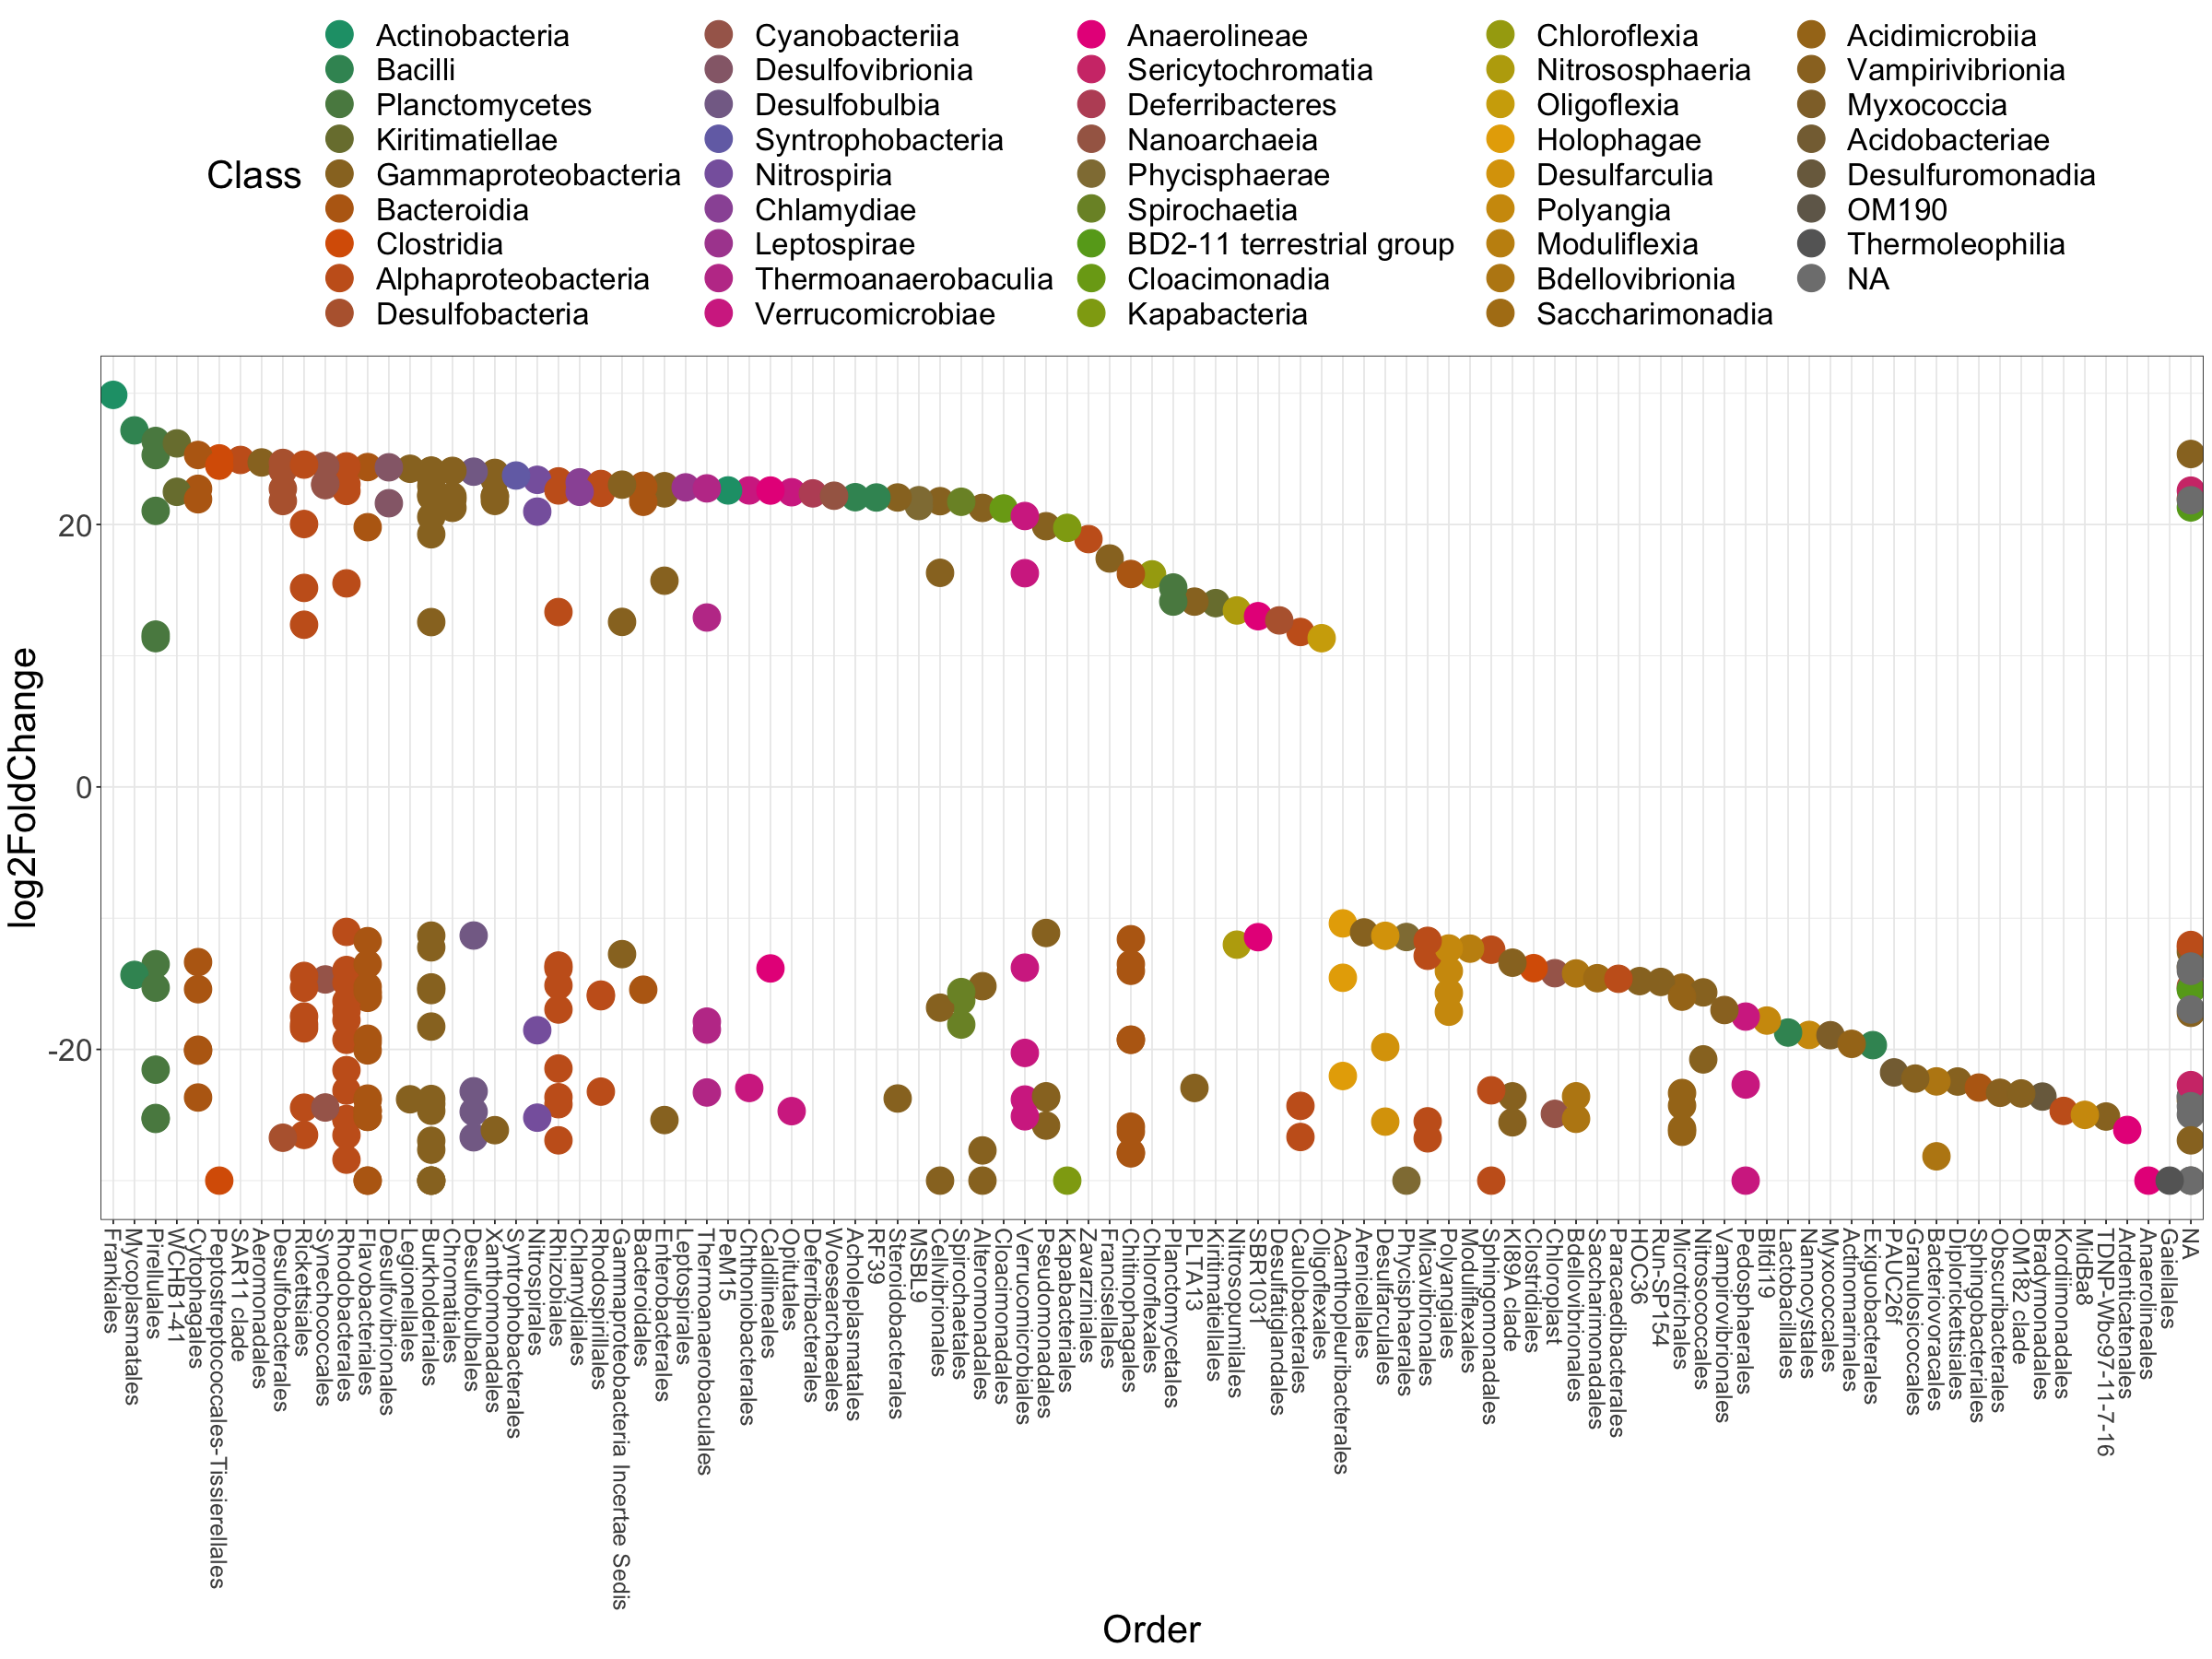

In [361]:
# Phylum order
x = tapply(sigdiv18$log2FoldChange, sigdiv18$Class, function(x) max(x))
x = sort(x, TRUE)
sigdiv18$Class = factor(as.character(sigdiv18$Class), levels=names(x))
# Genus order
x = tapply(sigdiv18$log2FoldChange, sigdiv18$Order, function(x) max(x))
x = sort(x, TRUE)
sigdiv18$Order = factor(as.character(sigdiv18$Order), levels=names(x))
ggplot(sigdiv18, aes(x=Order, y=log2FoldChange, color=Class)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           theme_bw()+
  theme(legend.position="top",axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=15), text=element_text(size=25))
           #ylim(-25,25)

In [328]:
respa18 = results(DE18ddspa, contrast=c("RFTM_pa", "0", "1"))
alpha = 0.05
sigpa18 = respa[which(respa18$padj < alpha), ]
sigpa18 = cbind(as(sigpa18, "data.frame"), as(tax_table(DE18)[rownames(sigpa18), ], "matrix"))

In [ ]:
DE_meas=read.csv("~/Documents/DE/DE_16S/De2018_measurements.csv", row.names=1)

In [39]:
meas=sample_data(DE_meas)

In [41]:
sample_data(DE18)=meas

In [42]:
sample_variables(DE18)

[1] "Number"               "Species"              "Color_Bucket"        
 [4] "V1"                   "UniqueID"             "Experiment"          
 [7] "Year"                 "Site"                 "Treatment1_Density"  
[10] "Treatment2_Diversity" "RFTM_score"           "peacrabs"            
[13] "Phase_1_DO"           "Phase_1_temp"         "Phase_2_DO"          
[16] "Phase_2_Temp"         "Overall_treatment"    "Weight_change"       
[19] "Length_change"        "Width_change"

In [44]:
DE18=subset_samples(DE18, !is.na(Weight_change))
DE18=subset_samples(DE18, Species=="CV")

In [45]:
DE18

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14760 taxa and 49 samples ]
sample_data() Sample Data:       [ 49 samples by 20 sample variables ]
tax_table()   Taxonomy Table:    [ 14760 taxa by 6 taxonomic ranks ]

In [46]:
DE18dds = phyloseq_to_deseq2(DE18, ~ scale(Weight_change, center = TRUE))

DE18dds = DESeq(DE18dds, test="Wald", fitType="parametric")


converting counts to integer mode

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [297]:
res = results(DE18dds, cooksCutoff = FALSE)
alpha = 0.01
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(DE18)[rownames(sigtab), ], "matrix"))
postab=sigtab[sigtab$log2FoldChange>0,]


ERROR: Error in is(object, "DESeqDataSet"): object 'DE18dds' not found


In [298]:
hightab=sigtab[sigtab$log2FoldChange>10,]


In [49]:
highgrowthASVs=row.names(hightab)

In [257]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(78)


Warning message:
“Removed 20 rows containing missing values (geom_point).”


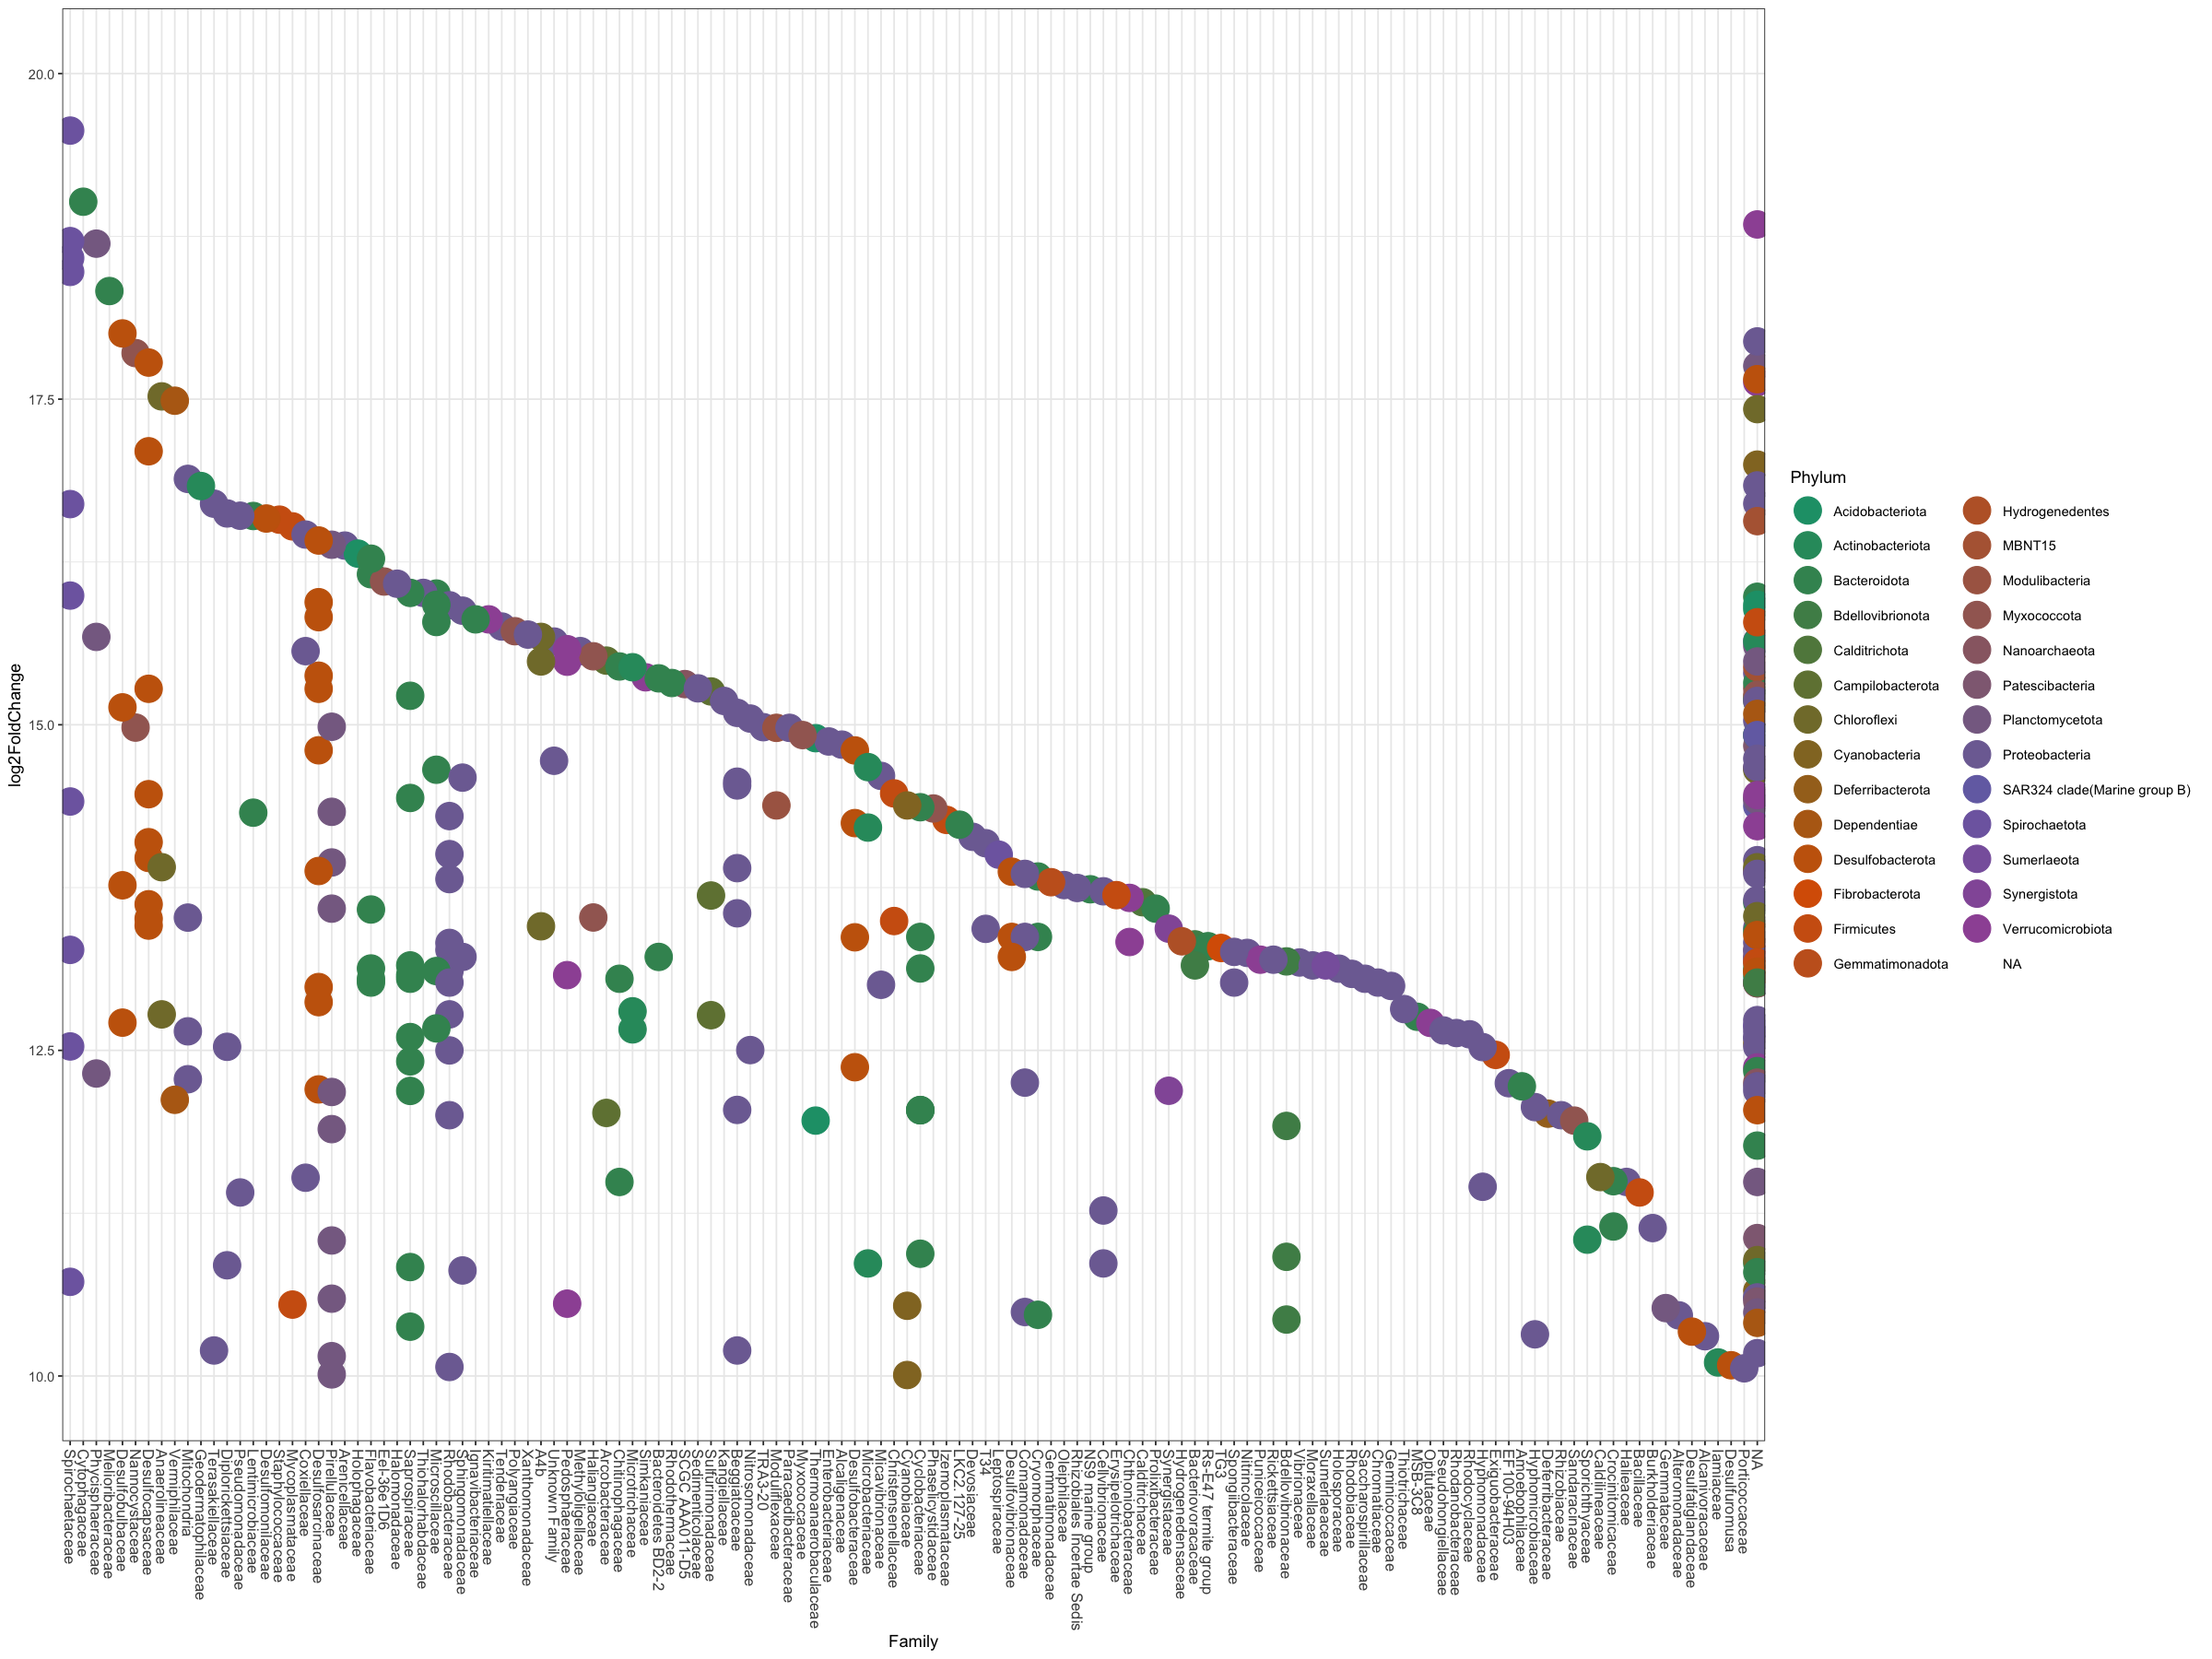

In [119]:
# Phylum order
x = tapply(hightab$log2FoldChange, hightab$Phylum, function(x) max(x))
x = sort(x, TRUE)
hightab$Class = factor(as.character(hightab$Phylum), levels=names(x))
# Genus order
x = tapply(hightab$log2FoldChange, hightab$Family, function(x) max(x))
x = sort(x, TRUE)
hightab$Family = factor(as.character(hightab$Family), levels=names(x))
ggplot(hightab, aes(x=Family, y=log2FoldChange, color=Phylum)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           ylim(10,20)+
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=10))

Warning message:
“Removed 718 rows containing missing values (geom_point).”


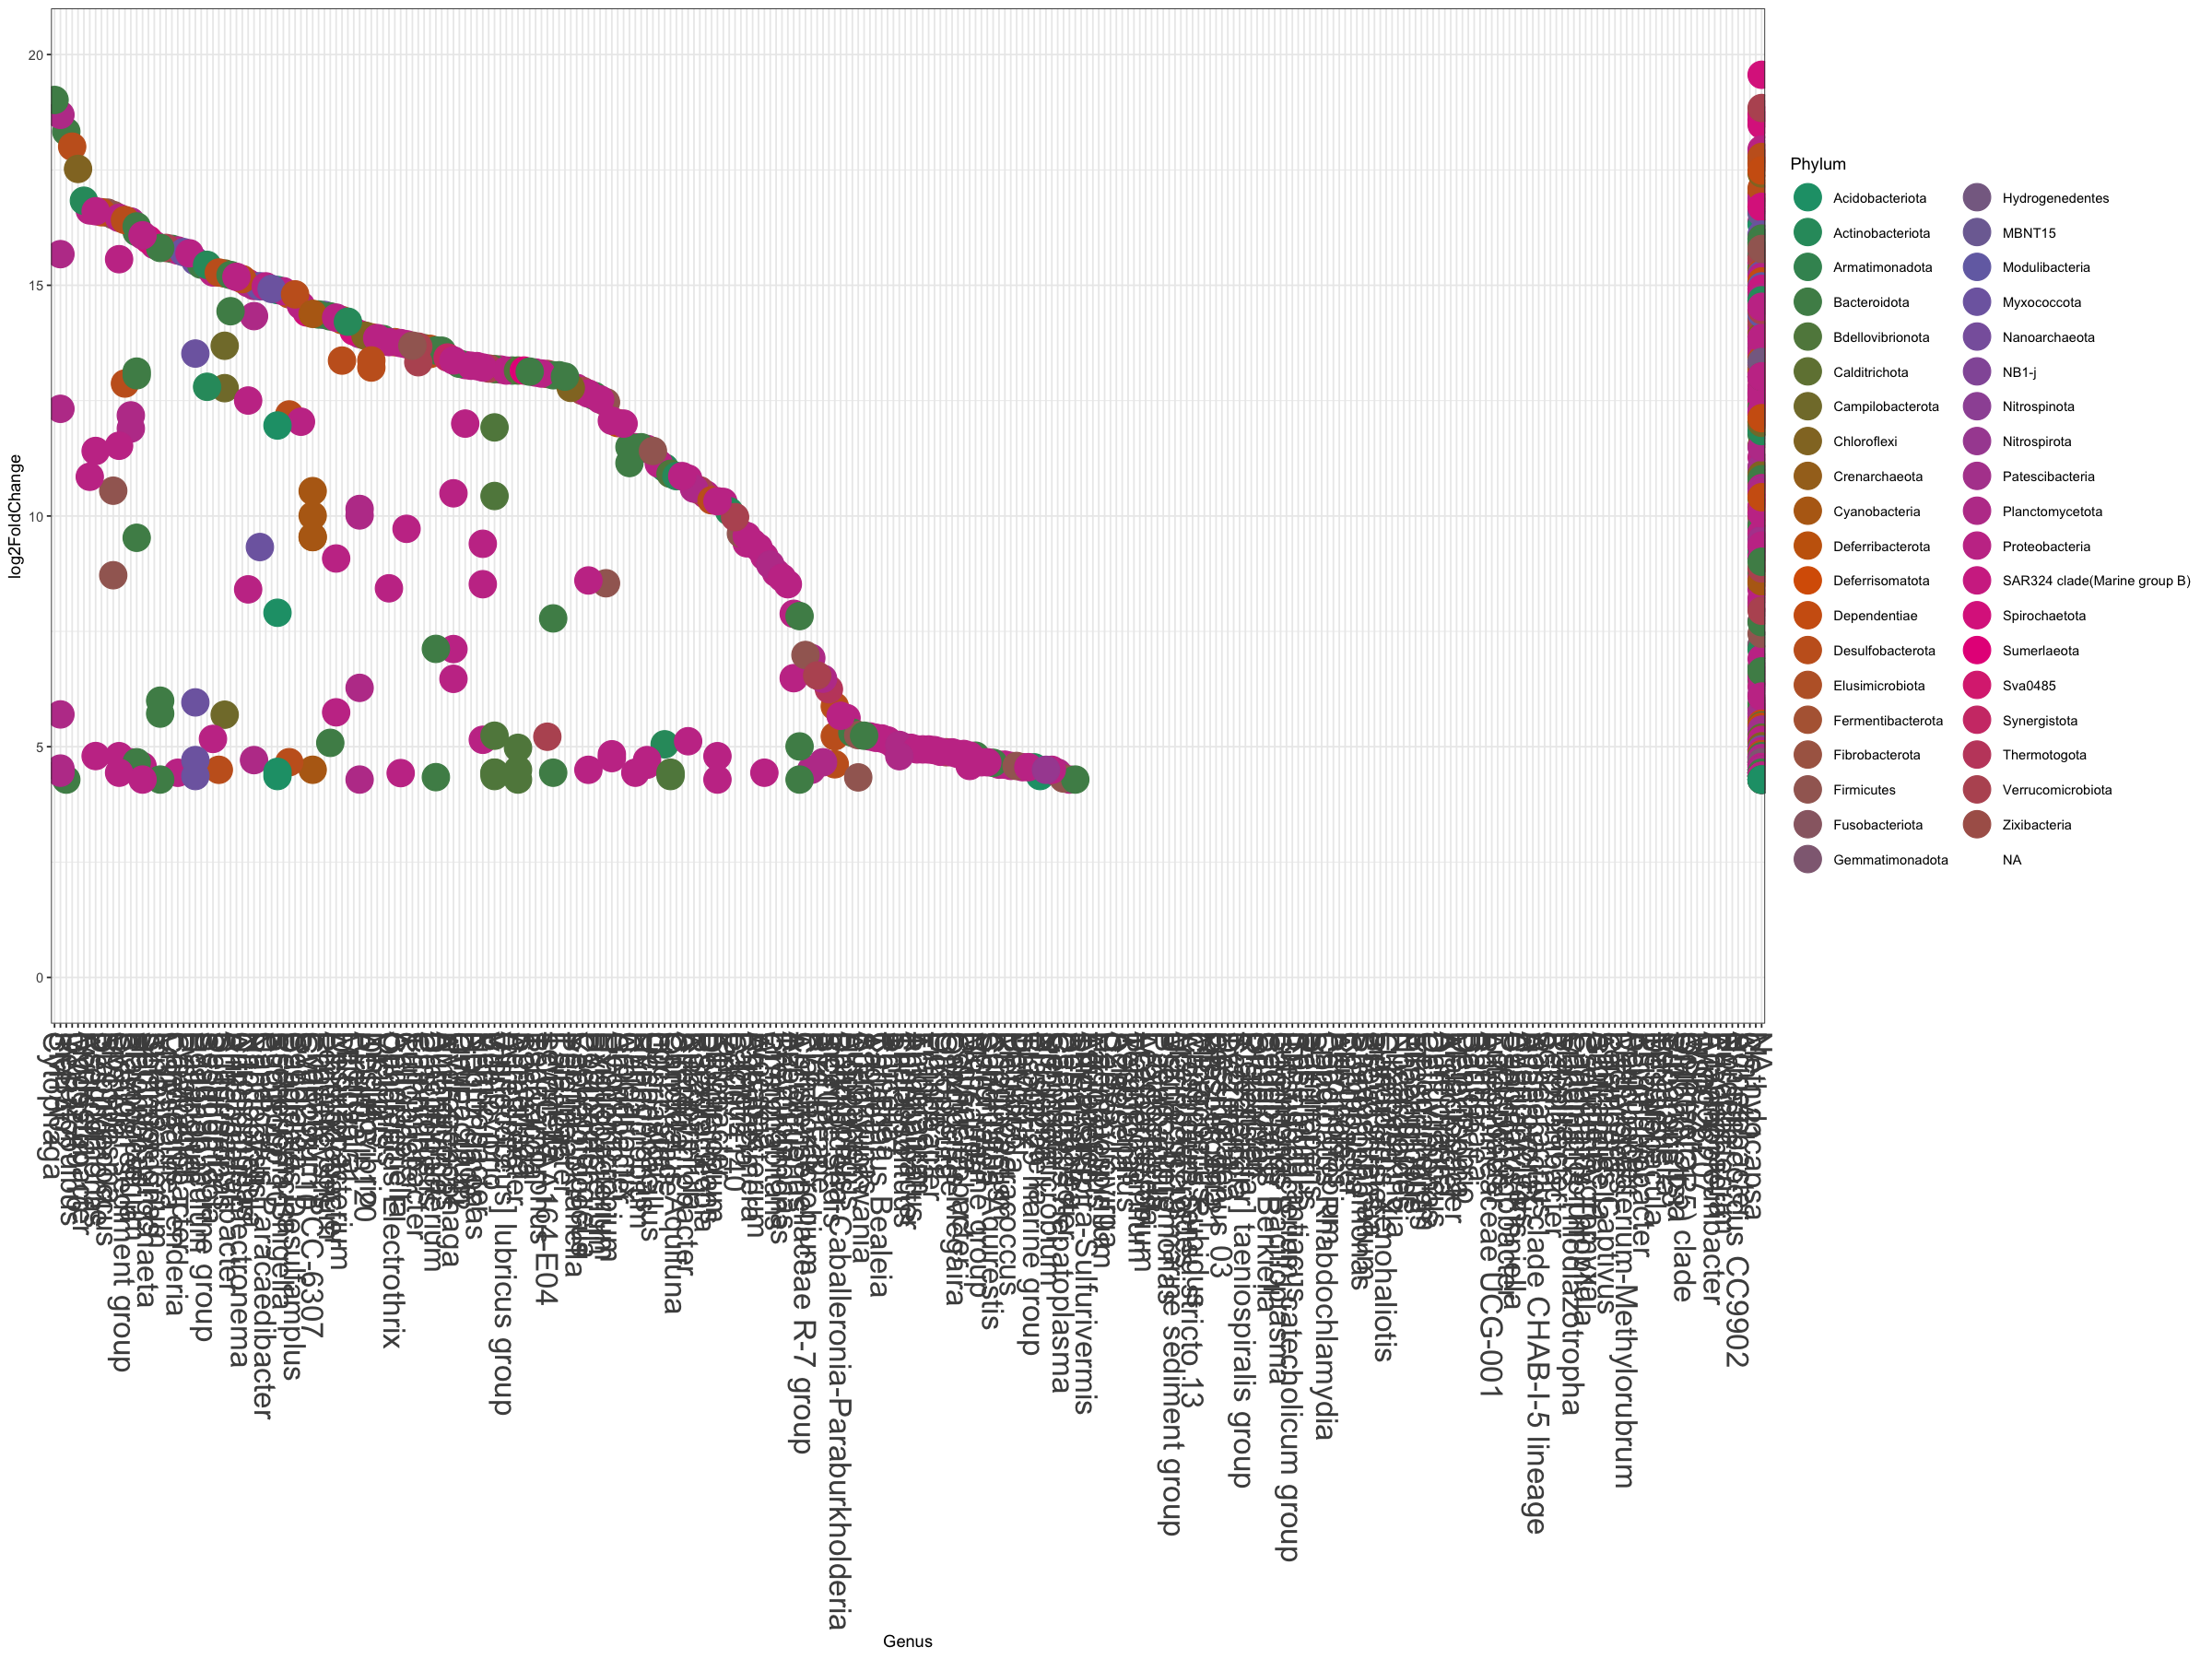

In [105]:

# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtab$Class = factor(as.character(sigtab$Phylum), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtab$Genus = factor(as.character(sigtab$Genus), levels=names(x))
ggplot(sigtab, aes(x=Genus, y=log2FoldChange, color=Phylum)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           ylim(0,20)+
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=20))

In [122]:
DE18_growthASVs=prune_taxa(DE18, taxa=highgrowthASVs)

In [281]:
DE18_growthASVs=transform_sample_counts(DE18_growthASVs, function(x) ifelse(x>=1, 1, 0))

In [287]:
proNums=as.data.frame(colSums(otu_table(DE18_growthASVs)))

In [289]:
samps=sample_data(DE18_growthASVs)

In [292]:
colnames(proNums)="proNum"

In [293]:
samps=merge(proNums, samps, by="row.names" )

In [ ]:
sa

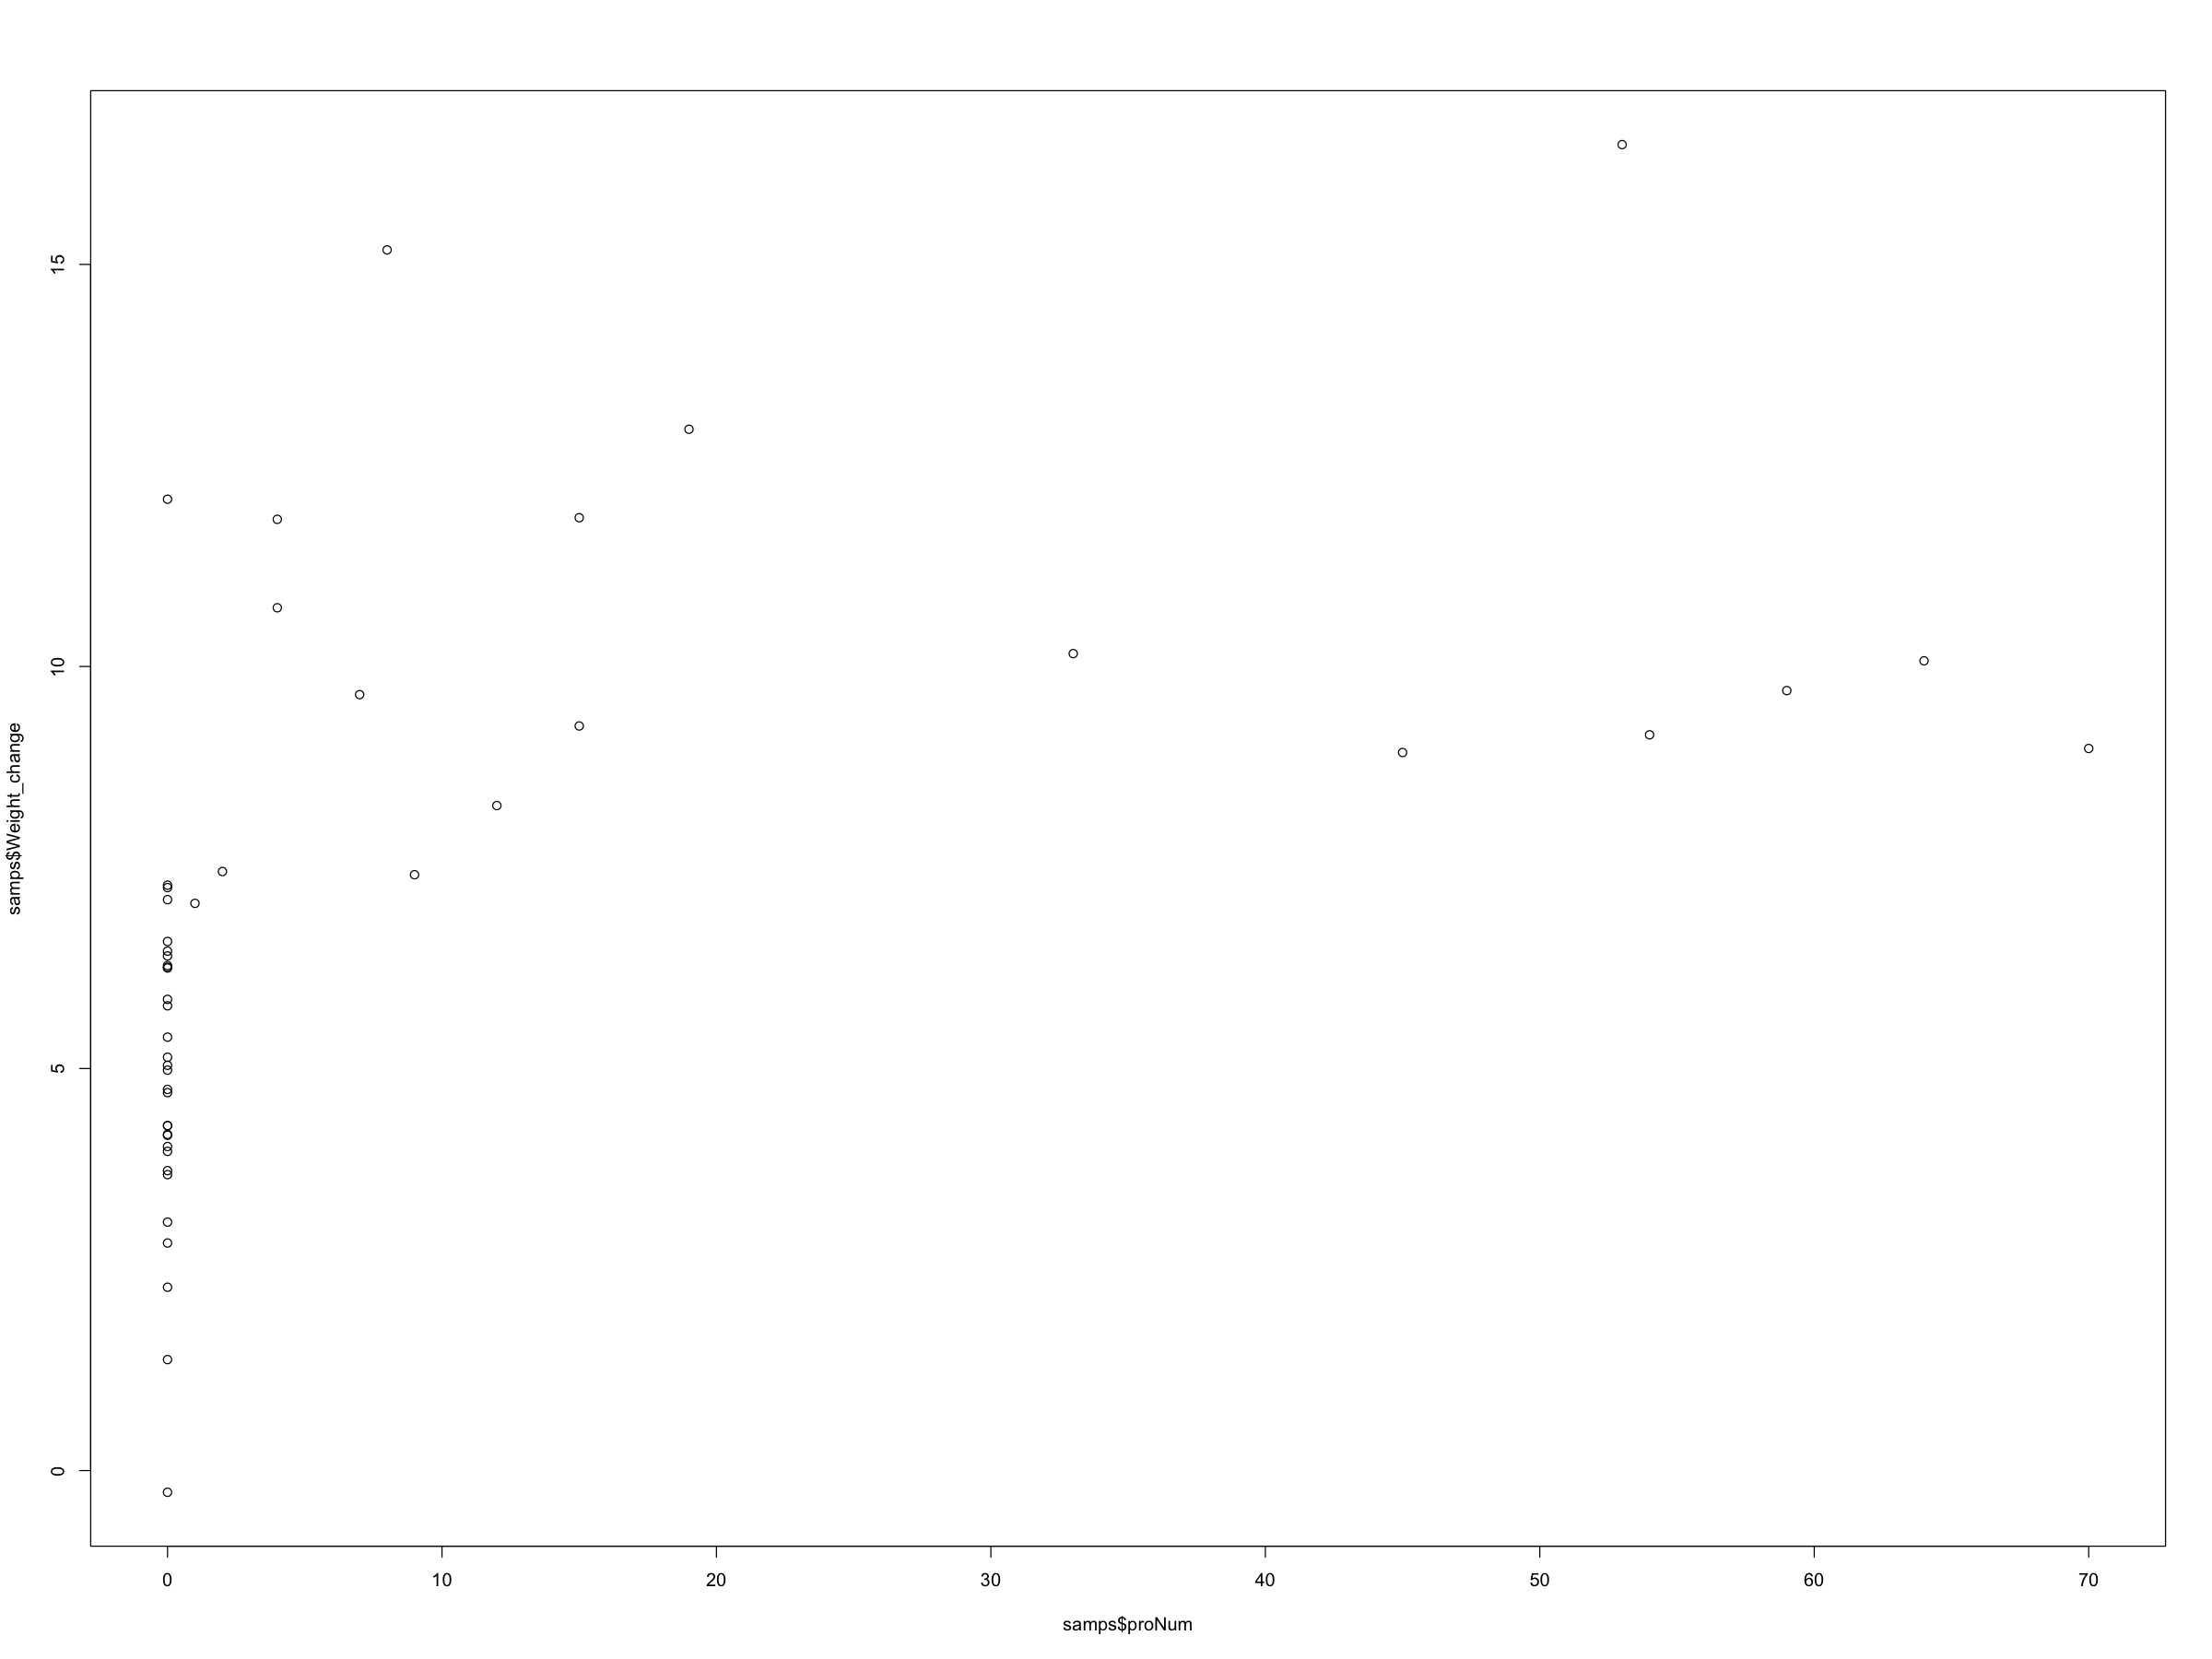

In [297]:
plot(samps$proNum, samps$Weight_change)

In [ ]:
OTU=transform_sample_counts(OTU, function(x) 1E6 * x/sum(x))

In [ ]:
rowsum(otu)

In [262]:
DE18ps=psmelt(DE18_growthASVs)

In [263]:
DE18ps=setorder(DE18ps, Weight_change)

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”


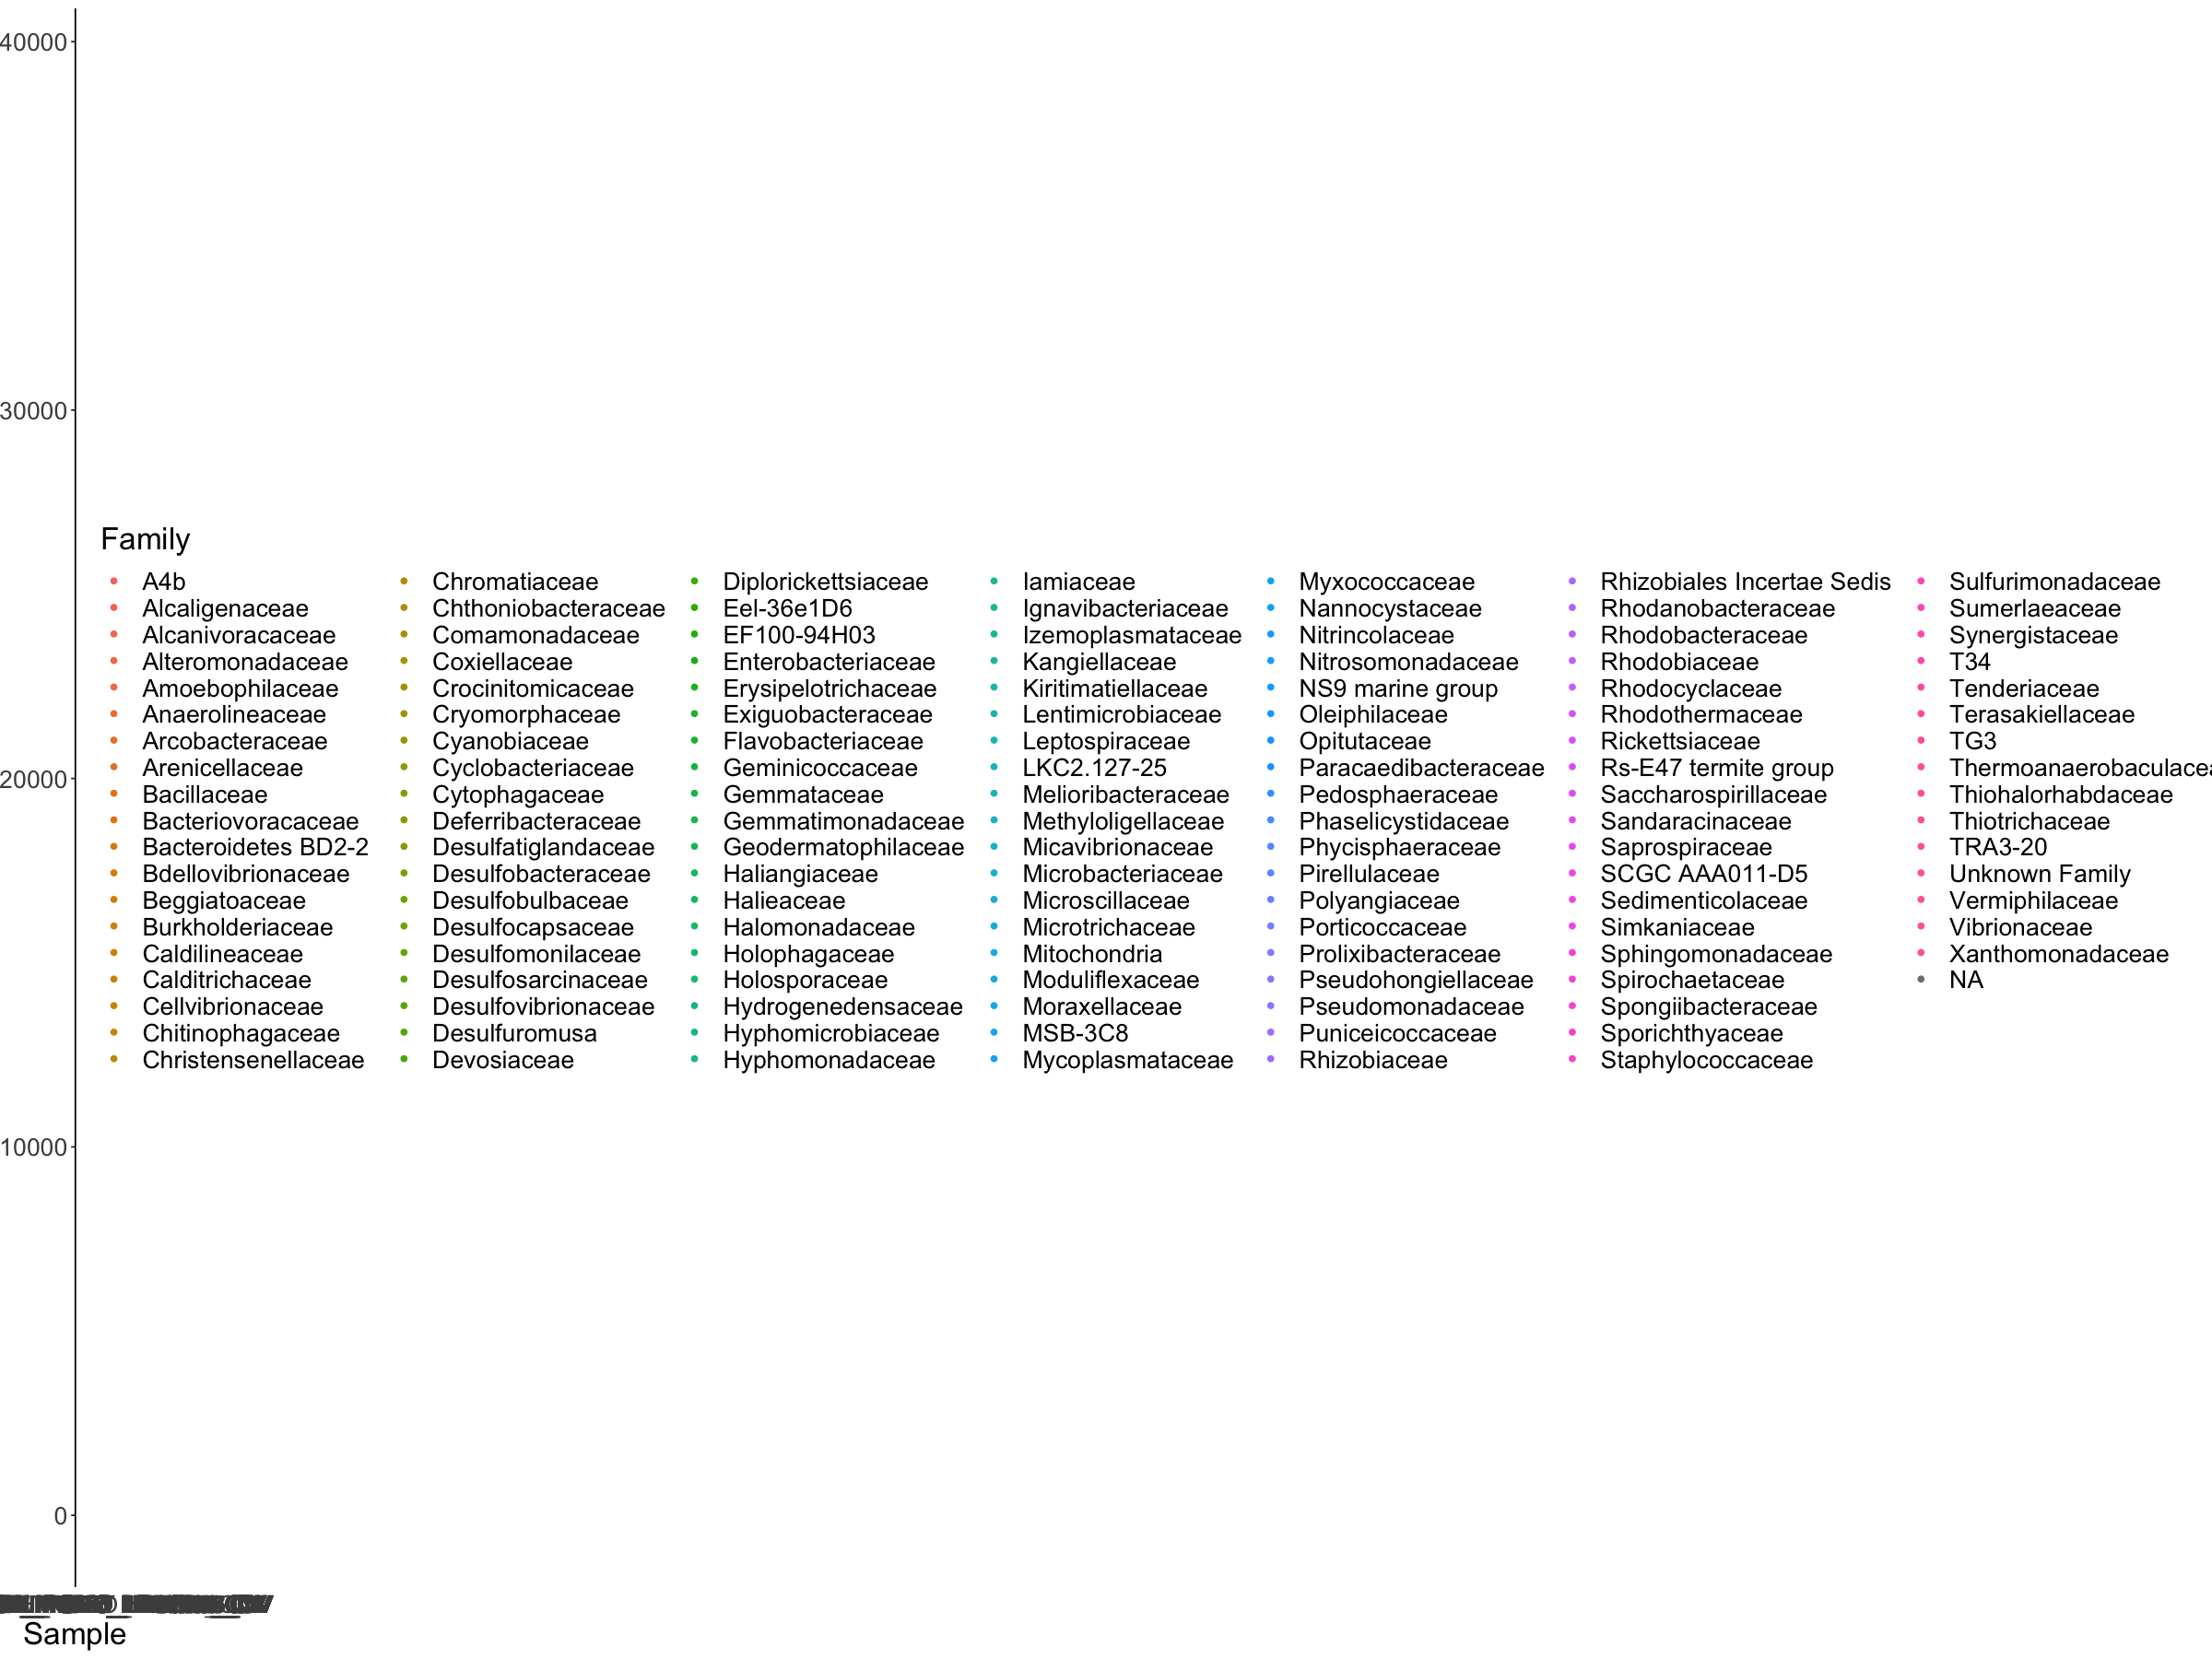

In [265]:
ggplot(DE18ps,  fill="Family") +
geom_point(aes(x=Sample, y=Abundance, color=Family, fill=Family))+
#scale_fill_manual(values=mycolors)+
#scale_color_manual(values=mycolors)+
theme_bw()+
theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), 
         text = element_text(size=20))

In [124]:
ggplot(DE18_growthASVs, aes(x=Abundance, y=Weight_change, color=Species))+
geom_point(aes(fill=Species), size=8)+
facet_grid(.~Treatment2_Diversity)+
theme_bw()+
geom_text(aes(label=Number), color="black", size=8)+
theme(legend.position = "none", text = element_text(size=20), axis.text.x = element_text(angle = 90))


ERROR: Error: `data` must be a data frame, or other object coercible by `fortify()`, not an S4 object with class phyloseq


In [126]:
newtab = data.table(pTime$data)
setorder(newtab, TIMEPOINT_NUMBER)
pTime$data <- newtab

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'S4'”


ERROR: Error in x[!nas]: object of type 'S4' is not subsettable


In [160]:
p=plot_bar(DE18_growthASVs,  fill="Phylum") 

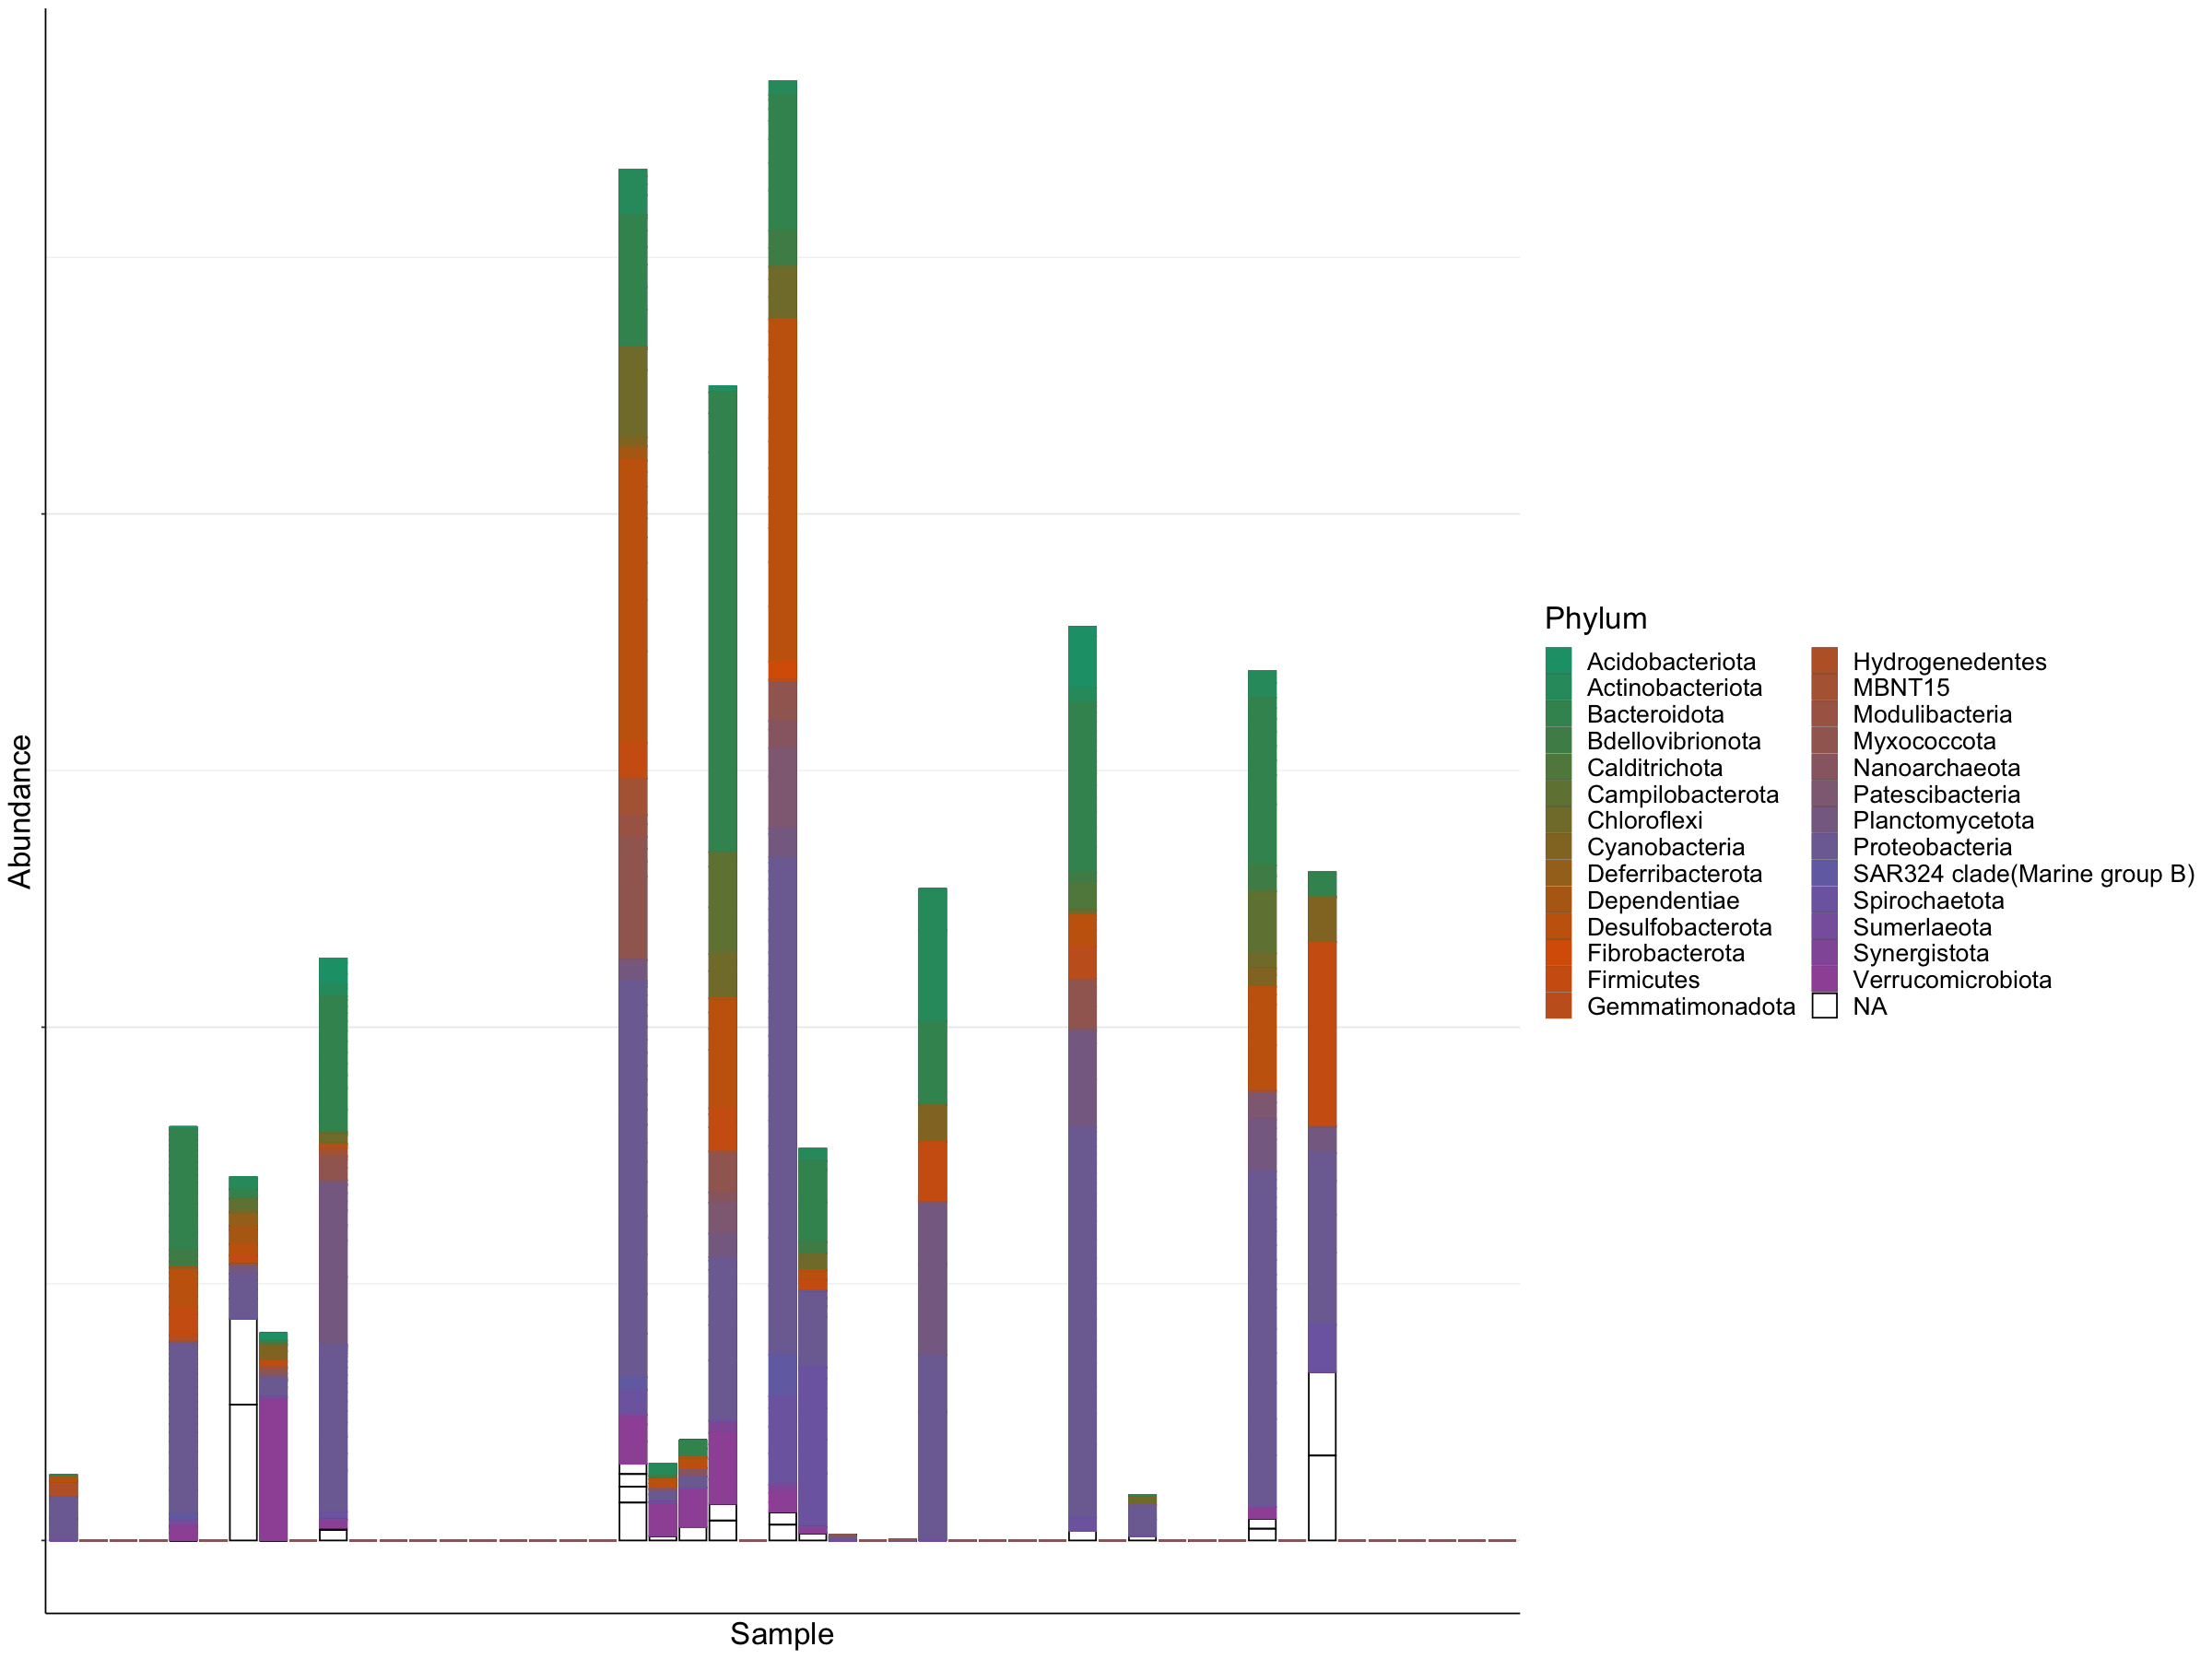

In [161]:
p+geom_bar(aes(x = reorder(Sample, Weight_change), color=Phylum, fill=Phylum), stat="identity", position="stack")+
scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
theme_bw()+
theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), 
          axis.text=element_blank(), text = element_text(size=20))

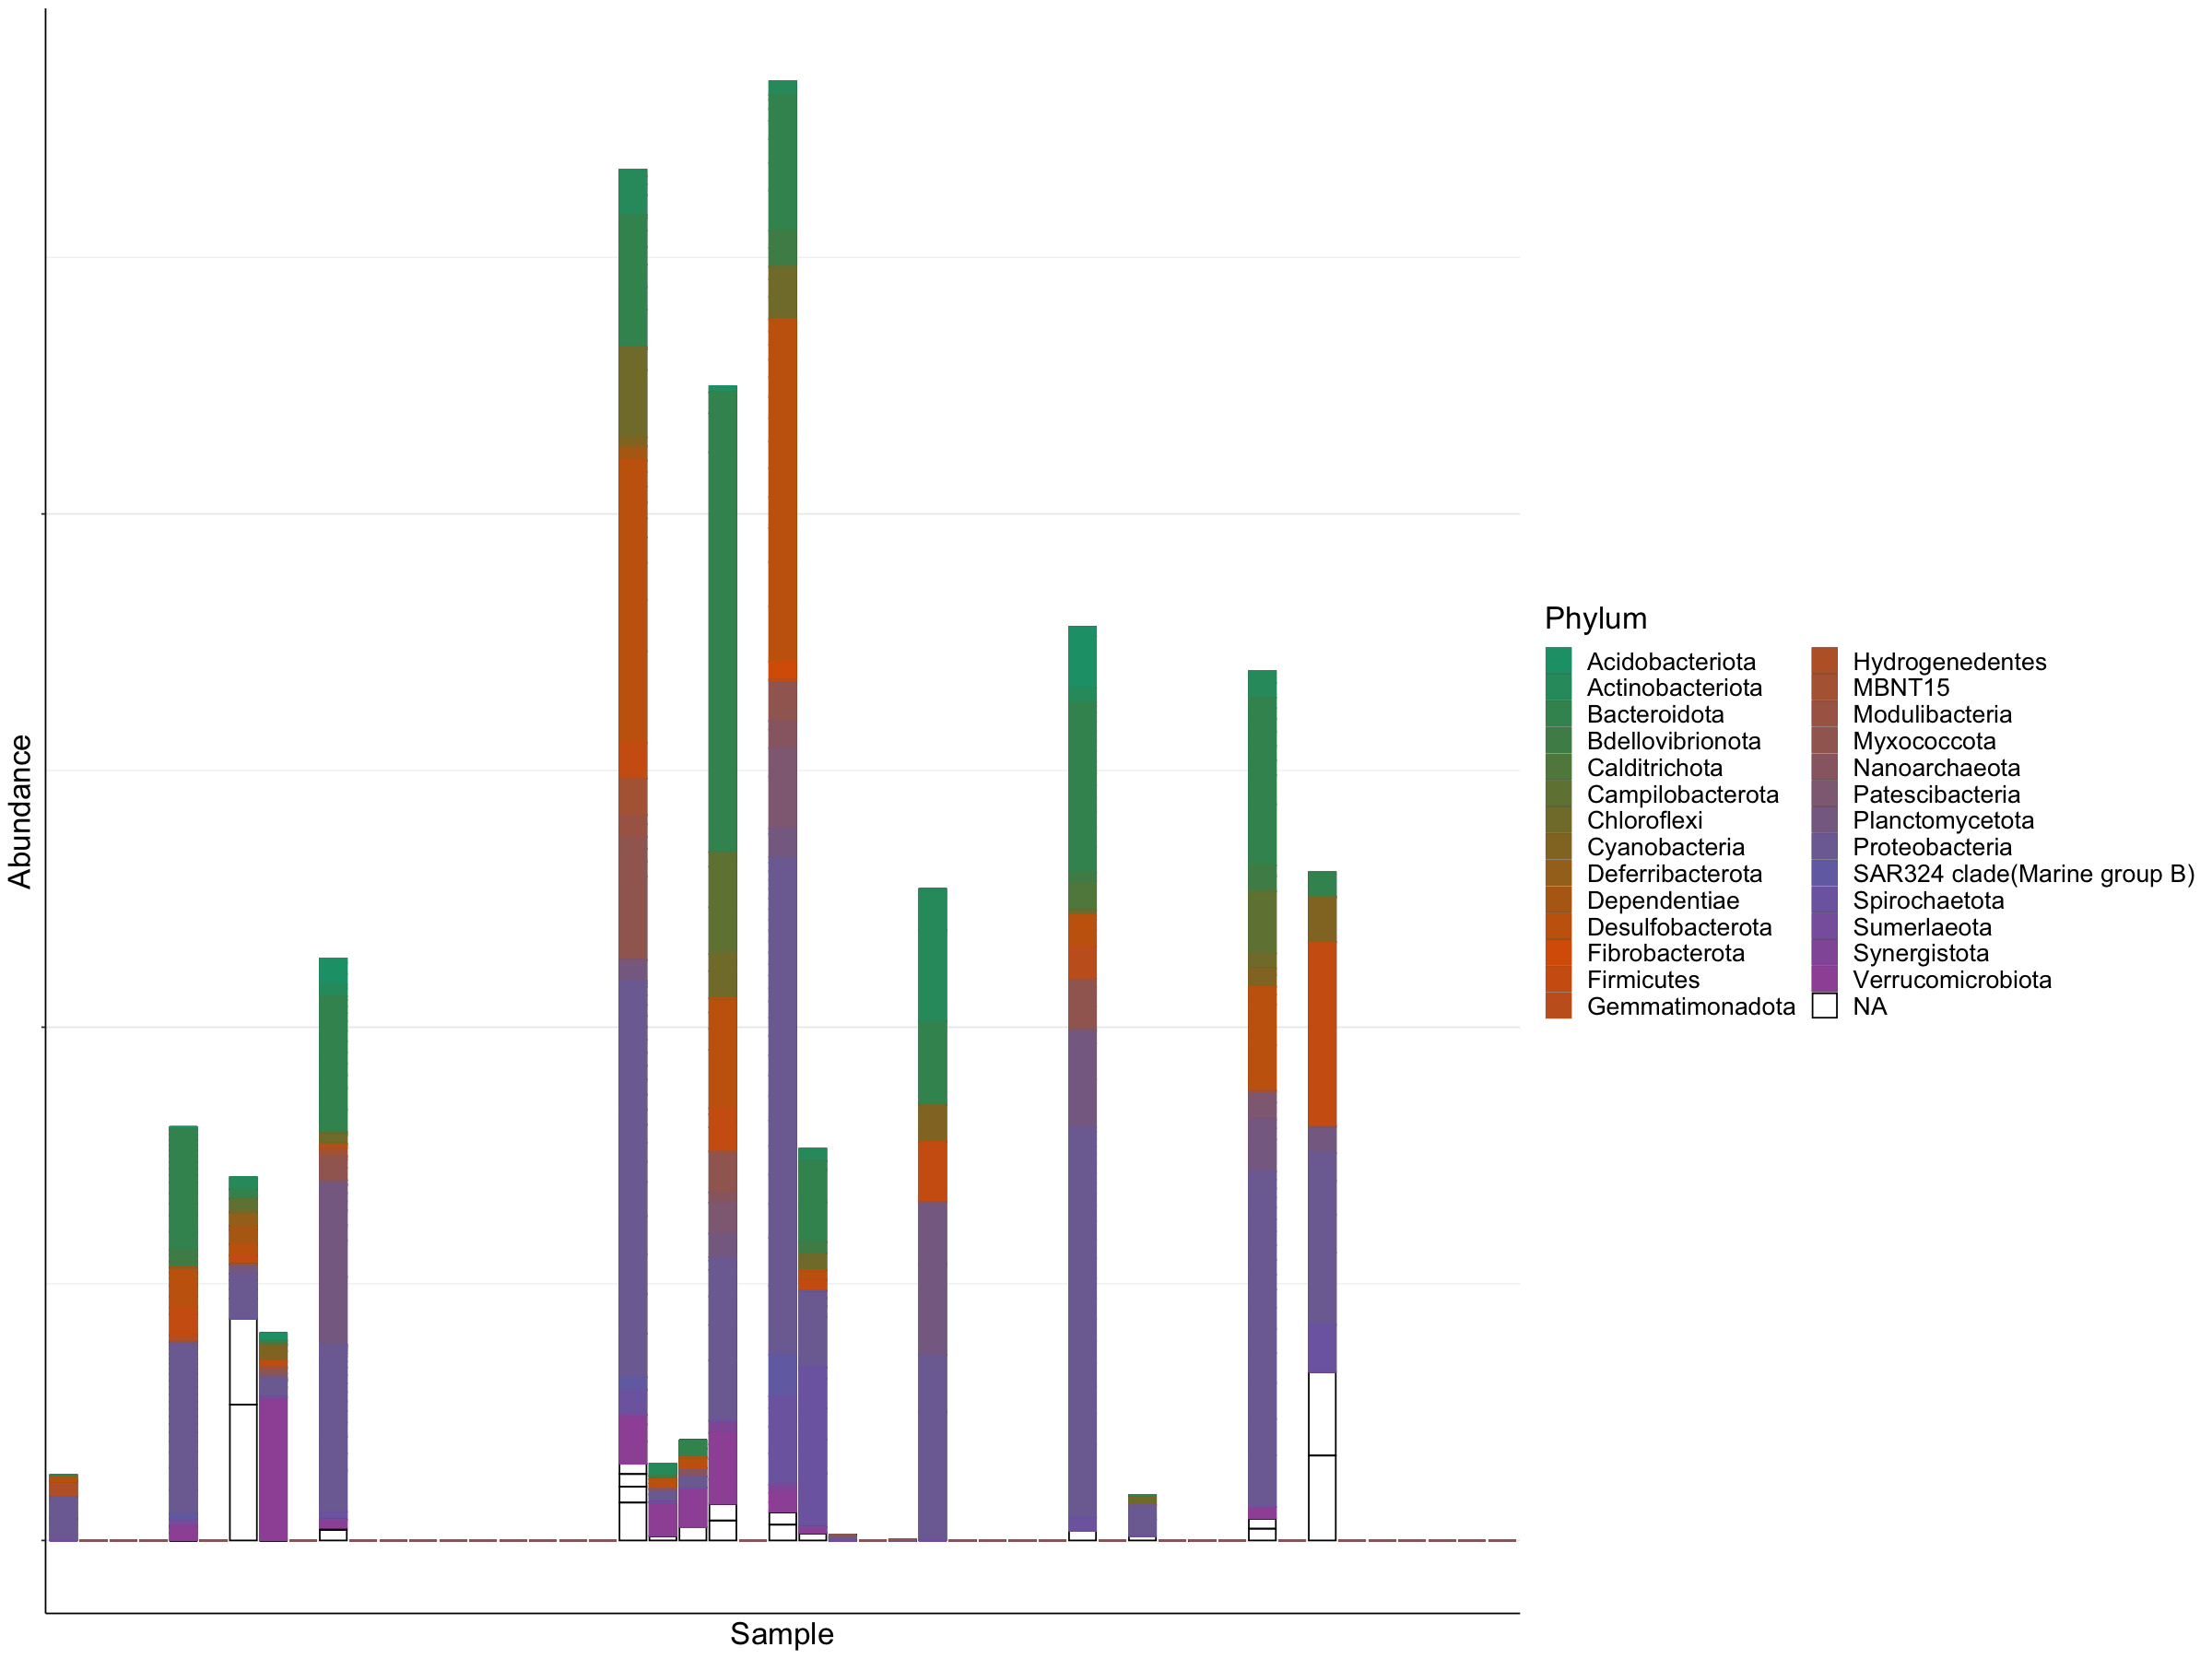

In [159]:
p

In [151]:
newtab = data.table(p$data)
setorder(newtab, Weight_change)
p$data <- newtab

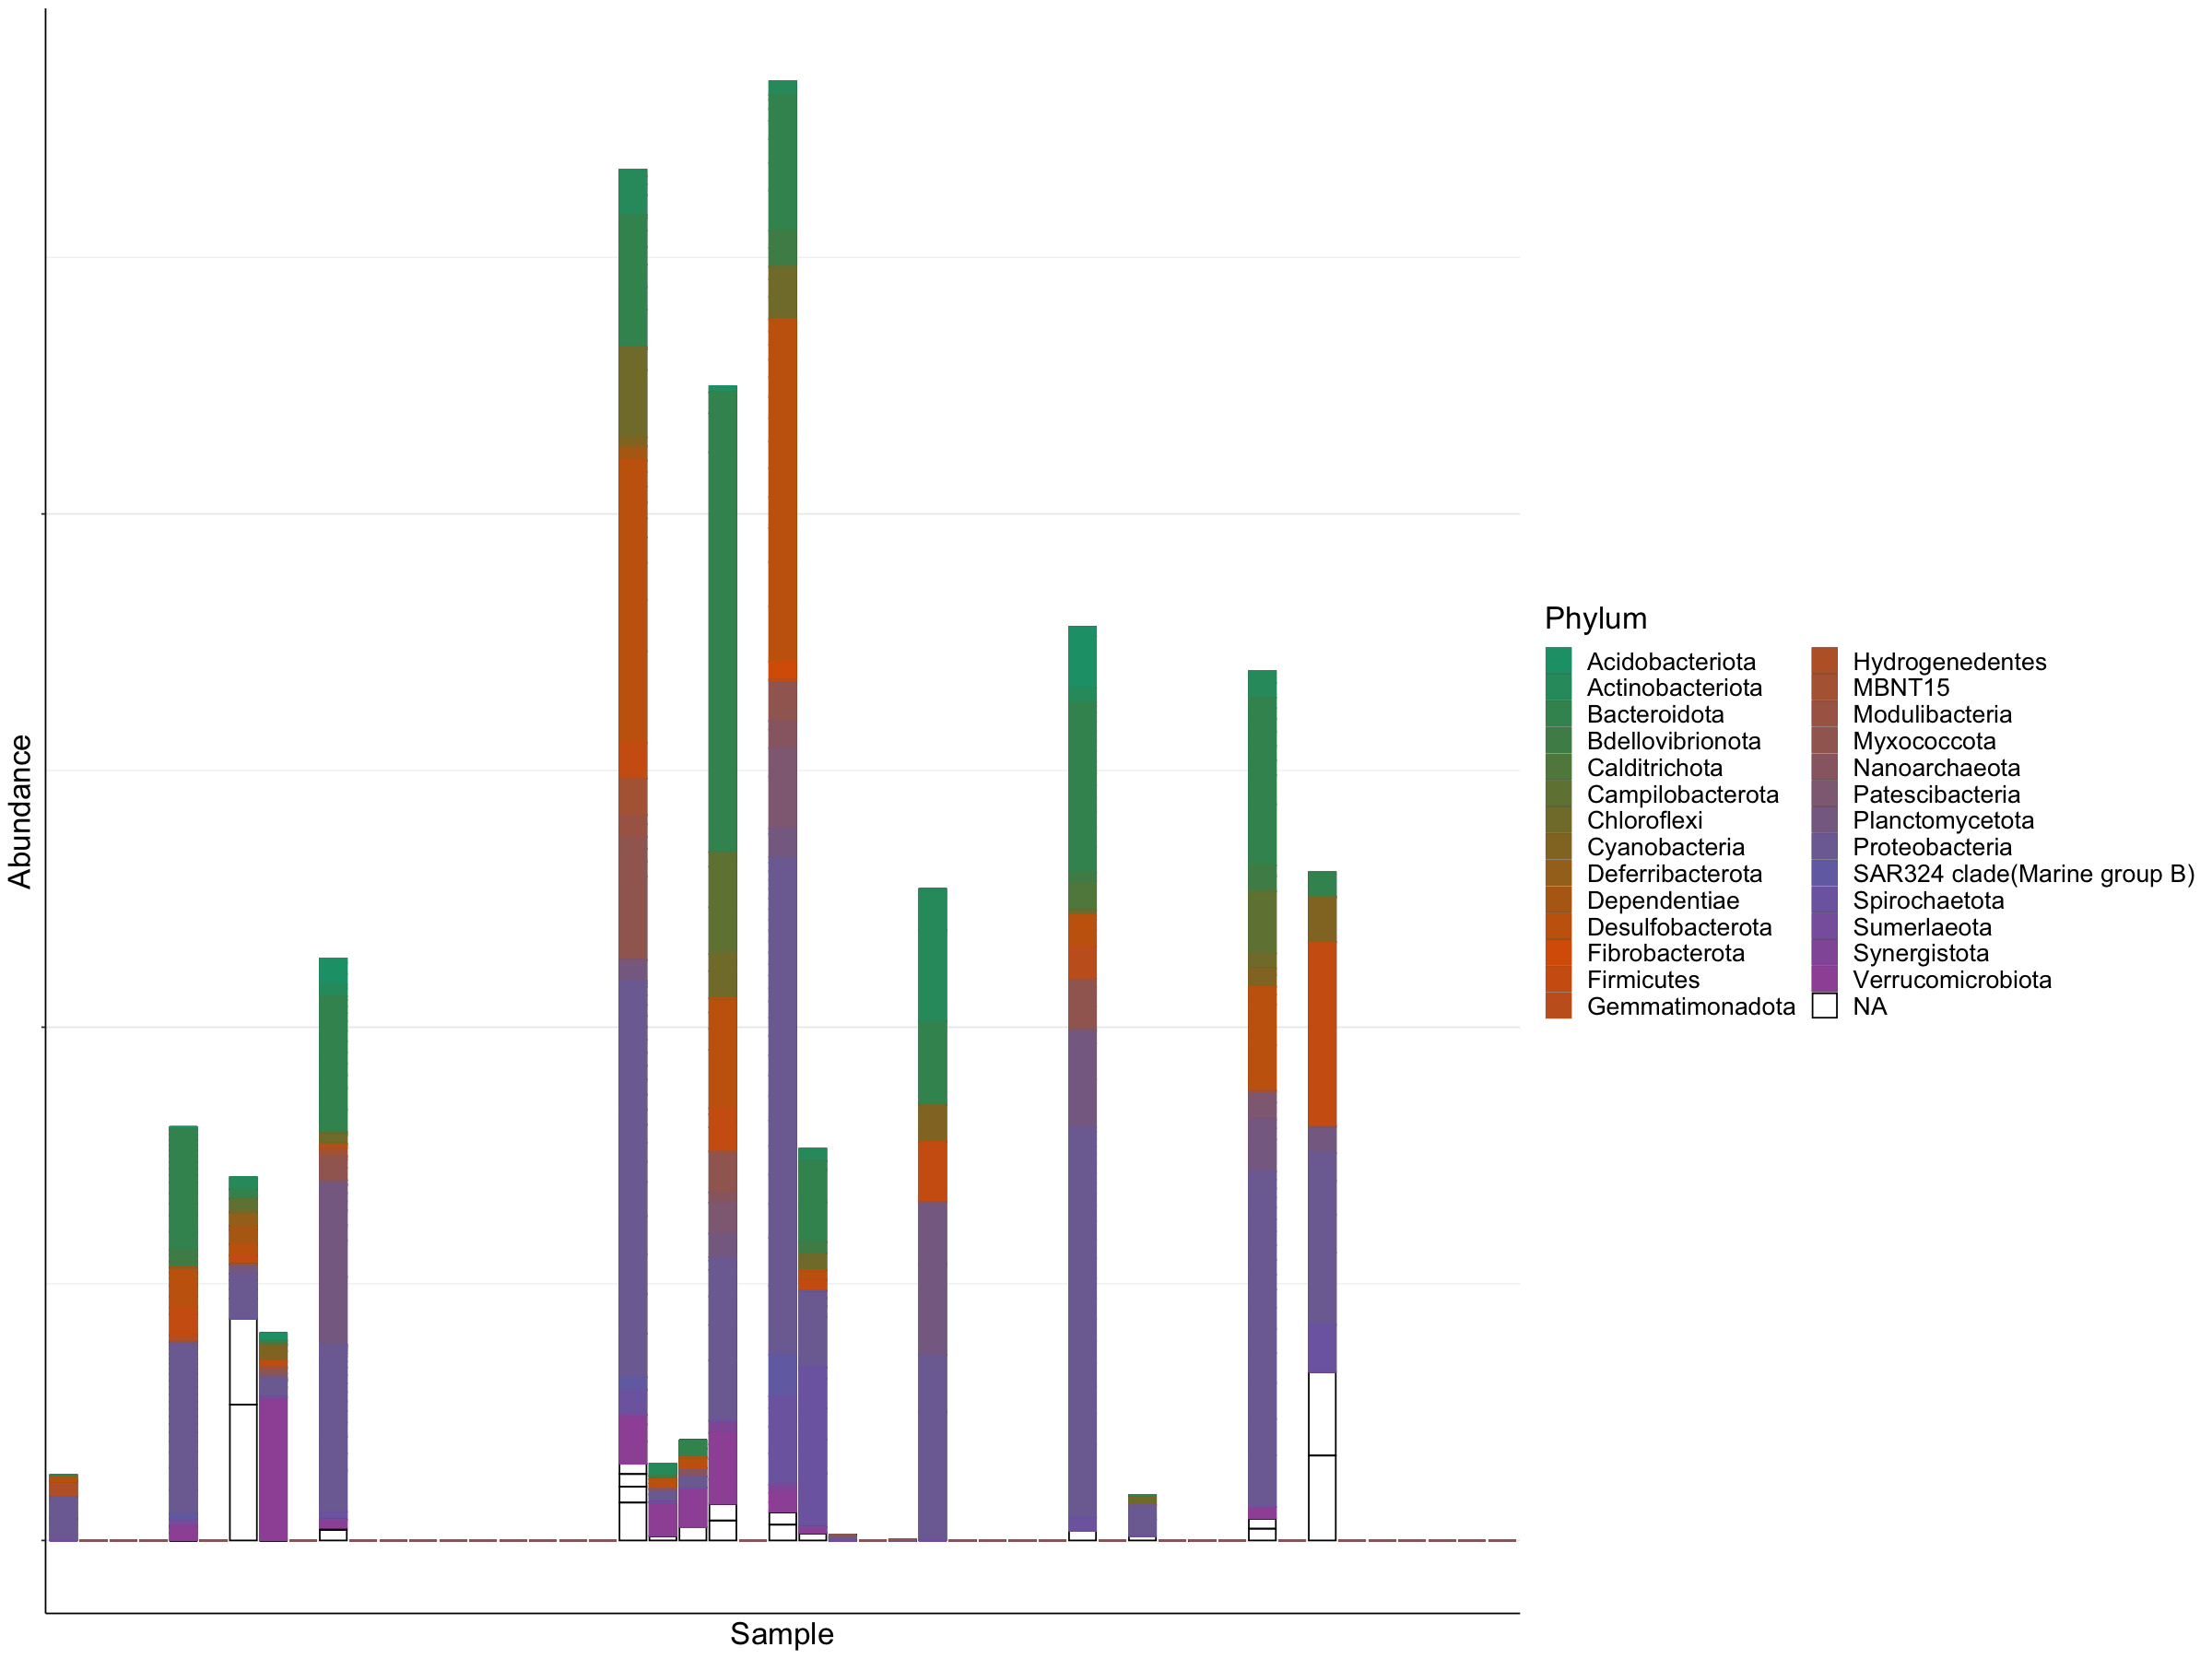

In [154]:
ggplot(tips2, aes(x = reorder(day, -perc), y = perc)) + geom_bar(stat = "identity")
